In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from scipy.linalg import pinv
from PIL import Image
from tensorflow.keras.models import Model
import joblib
import numpy as np
import os
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.spatial import distance
import os
import shutil
import random
from tqdm import tqdm  # Import tqdm for progress bars



print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
data_dir = "/content/drive/My Drive/CXR_train_images"
sampled_data_dir = "/content/drive/My Drive/CXR_sampled_dataset"

# Create the sampled dataset directory if it doesn't exist
if not os.path.exists(sampled_data_dir):
    os.makedirs(sampled_data_dir)

# Sample images from each class
for class_dir in os.listdir(data_dir):
    class_images = os.listdir(os.path.join(data_dir, class_dir))
    num_to_sample = min(200, len(class_images))
    sampled_class_images = random.sample(class_images, num_to_sample)
    new_class_dir = os.path.join(sampled_data_dir, class_dir)
    if not os.path.exists(new_class_dir):
        os.makedirs(new_class_dir)
    for image in sampled_class_images:
        shutil.copy2(os.path.join(data_dir, class_dir, image), os.path.join(new_class_dir, image))

# Image data generators for training and validation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.10)

train_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="training",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    sampled_data_dir,
    subset="validation",
    class_mode="binary",
    target_size=(224, 224),
    shuffle=True
)

Found 6146 images belonging to 2 classes.
Found 682 images belonging to 2 classes.


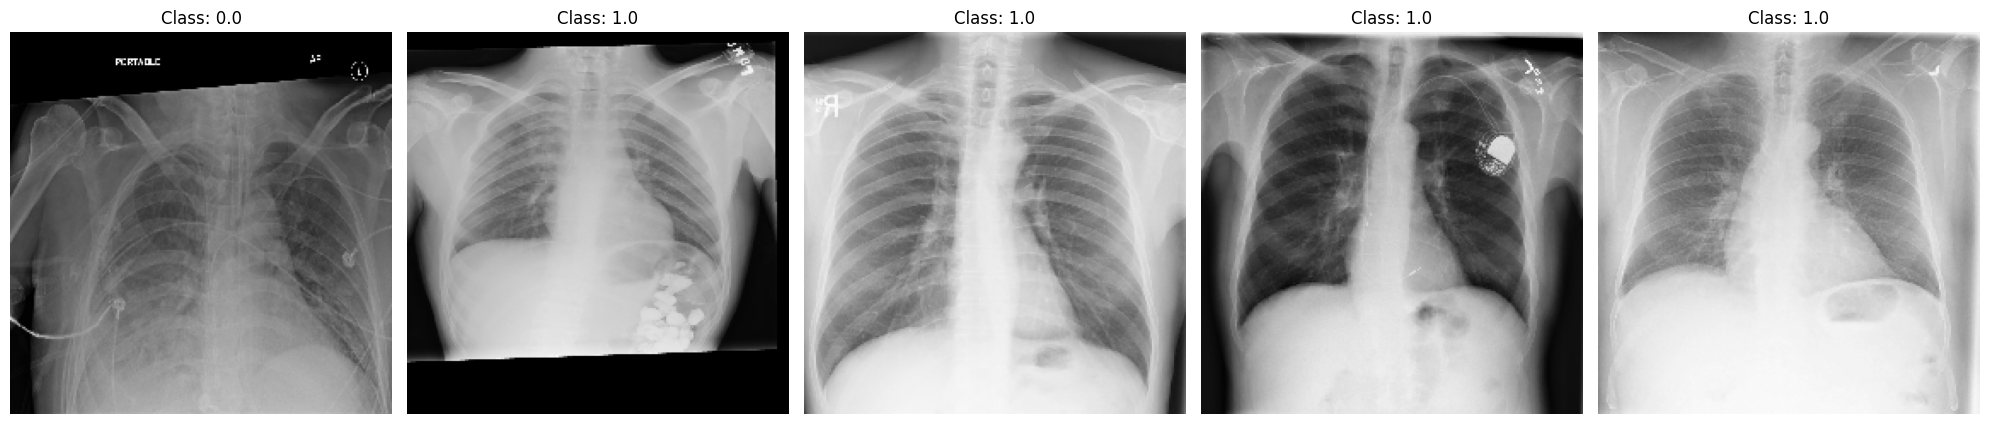

In [4]:
# Function to plot images
def plot_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.set_title(f"Class: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display 5 images from the training set
images, labels = next(train_generator)
plot_images(images[:5], labels[:5])


# Function to remove corrupted images
def check_and_delete_corrupted_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

check_and_delete_corrupted_images(sampled_data_dir)


In [5]:
# Function to remove corrupted images
def check_and_delete_corrupted_images(directory):
    for subdir, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print(f"Deleting corrupted image: {file_path}")
                os.remove(file_path)

check_and_delete_corrupted_images(sampled_data_dir)


Out-of-Distribution Images (Non-CXR):


<ipython-input-6-5c13f2b9d966>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((256, 256), Image.ANTIALIAS)


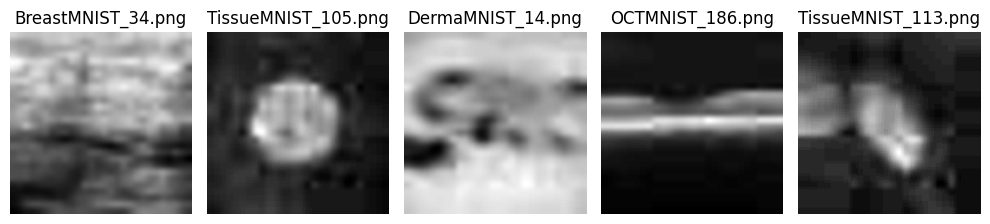

In-Distribution Images (CXR):


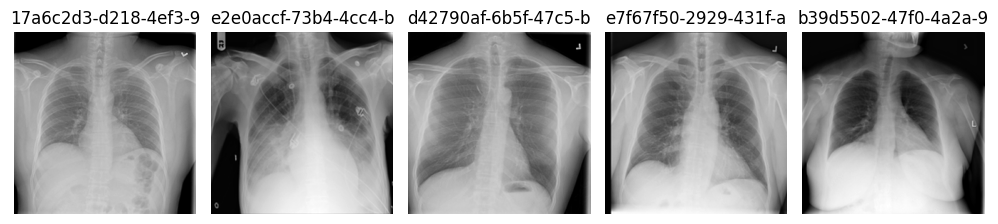

In [6]:
# Function to display random images from a directory
def display_random_images_from_directory(directory, num_images=5):
    image_names = [name for name in os.listdir(directory) if name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    random_images = random.sample(image_names, min(num_images, len(image_names)))

    plt.figure(figsize=(10, 10))
    for i, image_name in enumerate(random_images):
        img_path = os.path.join(directory, image_name)
        img = Image.open(img_path).convert('L')
        img = img.resize((256, 256), Image.ANTIALIAS)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(image_name[:20])
    plt.tight_layout()
    plt.show()

# Paths to the testing image folders
out_dist_folder = '/content/drive/MyDrive/out-dist-cxr'
in_dist_folder = '/content/drive/MyDrive/in_dist_pool'

# Display 5 random images from each testing folder
print("Out-of-Distribution Images (Non-CXR):")
display_random_images_from_directory(out_dist_folder)

print("In-Distribution Images (CXR):")
display_random_images_from_directory(in_dist_folder)

In [ ]:
model = Model(inputs=model.input, outputs=model.get_layer('block5_pool').output)

In [8]:
def extract_features_from_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB since VGG16 expects 3 channels
    img = img.resize(target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array * 255)
    features = model.predict(img_array)
    return features.flatten()

def extract_features_from_folder(folder_path):
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return np.array([]), []
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
    features = []
    filenames = []
    for img_path in tqdm(image_paths):
        try:
            img_features = extract_features_from_image(img_path)
            features.append(img_features)
            filenames.append(os.path.basename(img_path))
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    return np.array(features), filenames


def extract_features_from_generator(generator, model, num_samples):
    batch_size = generator.batch_size
    total_batches = (num_samples // batch_size) + (num_samples % batch_size > 0)
    all_features = []

    for _ in tqdm(range(total_batches)):
        batch_images, _ = next(generator)
        batch_features = model.predict(preprocess_input(batch_images * 255)).reshape(batch_images.shape[0], -1)
        all_features.append(batch_features)

    return np.vstack(all_features)


In [9]:
# Assuming train_generator is already defined and set up
num_samples = train_generator.samples
training_features = extract_features_from_generator(train_generator, model, num_samples)


  0%|          | 0/193 [00:00<?, ?it/s]

1/1 [==============================] - 4s 4s/step


  1%|          | 1/193 [00:04<13:35,  4.25s/it]

1/1 [==============================] - 0s 33ms/step


  1%|          | 2/193 [00:04<06:56,  2.18s/it]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 3/193 [00:05<04:49,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 4/193 [00:06<03:46,  1.20s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 5/193 [00:07<03:11,  1.02s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 6/193 [00:07<02:52,  1.08it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 7/193 [00:08<02:39,  1.17it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 8/193 [00:09<02:32,  1.21it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 9/193 [00:10<02:26,  1.26it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 10/193 [00:10<02:23,  1.28it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 11/193 [00:11<02:20,  1.30it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 12/193 [00:12<02:17,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 13/193 [00:13<02:14,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 14/193 [00:13<02:11,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 15/193 [00:14<02:10,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 16/193 [00:15<02:09,  1.36it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 17/193 [00:15<02:10,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 18/193 [00:16<02:07,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 19/193 [00:17<02:06,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 20/193 [00:18<02:04,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 21/193 [00:18<02:03,  1.39it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 22/193 [00:19<02:04,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 23/193 [00:20<02:02,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 24/193 [00:20<02:03,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 25/193 [00:21<02:01,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 26/193 [00:22<01:59,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 27/193 [00:23<02:01,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 28/193 [00:23<02:00,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 29/193 [00:24<02:00,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 30/193 [00:25<01:57,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 31/193 [00:26<01:57,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 32/193 [00:26<01:55,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 33/193 [00:27<01:54,  1.40it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 34/193 [00:28<01:55,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 35/193 [00:28<01:53,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 36/193 [00:29<01:54,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 37/193 [00:30<01:52,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 38/193 [00:31<01:51,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 39/193 [00:31<01:56,  1.32it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 40/193 [00:32<01:52,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 41/193 [00:33<01:51,  1.36it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 42/193 [00:34<01:49,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 43/193 [00:34<01:49,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 44/193 [00:35<01:48,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 45/193 [00:36<01:46,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 46/193 [00:37<01:47,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 47/193 [00:37<01:46,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 48/193 [00:38<01:45,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 49/193 [00:39<01:44,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 50/193 [00:39<01:42,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 51/193 [00:40<01:45,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 52/193 [00:41<01:45,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 53/193 [00:42<01:44,  1.34it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 54/193 [00:42<01:42,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 55/193 [00:43<01:41,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 56/193 [00:44<01:39,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 57/193 [00:45<01:38,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 58/193 [00:45<01:37,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 59/193 [00:46<01:36,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 60/193 [00:47<01:37,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 61/193 [00:47<01:35,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 62/193 [00:48<01:35,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 63/193 [00:49<01:34,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 64/193 [00:50<01:32,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 65/193 [00:50<01:32,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 66/193 [00:51<01:31,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 67/193 [00:52<01:31,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 68/193 [00:53<01:30,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 69/193 [00:53<01:28,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 70/193 [00:54<01:28,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 71/193 [00:55<01:26,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 72/193 [00:55<01:26,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 73/193 [00:56<01:25,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 74/193 [00:57<01:25,  1.39it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 75/193 [00:57<01:24,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 76/193 [00:58<01:24,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 77/193 [00:59<01:22,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 78/193 [01:00<01:21,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 79/193 [01:00<01:21,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 80/193 [01:01<01:20,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 81/193 [01:02<01:19,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 82/193 [01:02<01:19,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 83/193 [01:03<01:19,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 84/193 [01:04<01:18,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 85/193 [01:05<01:18,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 86/193 [01:05<01:17,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 87/193 [01:06<01:16,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 88/193 [01:07<01:16,  1.37it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 89/193 [01:08<01:15,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 90/193 [01:08<01:14,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 91/193 [01:09<01:13,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 92/193 [01:10<01:12,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 93/193 [01:10<01:12,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 94/193 [01:11<01:12,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 95/193 [01:12<01:10,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 96/193 [01:13<01:10,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 97/193 [01:13<01:09,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 98/193 [01:14<01:08,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 99/193 [01:15<01:07,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 100/193 [01:15<01:06,  1.41it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 101/193 [01:16<01:05,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 102/193 [01:17<01:04,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 103/193 [01:18<01:05,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 104/193 [01:18<01:04,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 105/193 [01:19<01:04,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 106/193 [01:20<01:03,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 107/193 [01:21<01:02,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 108/193 [01:21<01:01,  1.38it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 109/193 [01:22<01:00,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 110/193 [01:23<00:59,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 111/193 [01:23<00:58,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 112/193 [01:24<00:58,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 113/193 [01:25<00:57,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 114/193 [01:26<00:56,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 115/193 [01:26<00:55,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 116/193 [01:27<00:54,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 117/193 [01:28<00:54,  1.41it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 118/193 [01:28<00:52,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 119/193 [01:29<00:52,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 120/193 [01:30<00:51,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 121/193 [01:31<00:51,  1.39it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 122/193 [01:31<00:51,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 123/193 [01:32<00:51,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 124/193 [01:33<00:49,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 125/193 [01:33<00:49,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 126/193 [01:34<00:47,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 127/193 [01:35<00:46,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 128/193 [01:36<00:46,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 129/193 [01:36<00:45,  1.41it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 130/193 [01:37<00:45,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 131/193 [01:38<00:44,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 132/193 [01:38<00:43,  1.40it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 133/193 [01:39<00:42,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 134/193 [01:40<00:43,  1.36it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 135/193 [01:41<00:43,  1.34it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 136/193 [01:41<00:42,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 137/193 [01:42<00:42,  1.32it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 138/193 [01:43<00:41,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 139/193 [01:44<00:40,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 140/193 [01:44<00:39,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 141/193 [01:45<00:38,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 142/193 [01:46<00:37,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 143/193 [01:47<00:36,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 144/193 [01:47<00:35,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 145/193 [01:48<00:34,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 146/193 [01:49<00:33,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 147/193 [01:49<00:32,  1.40it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 148/193 [01:50<00:32,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 149/193 [01:51<00:31,  1.39it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 150/193 [01:52<00:31,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 151/193 [01:52<00:30,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 152/193 [01:53<00:29,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 153/193 [01:54<00:29,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 154/193 [01:55<00:28,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 155/193 [01:55<00:27,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 156/193 [01:56<00:26,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 157/193 [01:57<00:26,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 158/193 [01:58<00:25,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 159/193 [01:58<00:25,  1.35it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 160/193 [01:59<00:24,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 161/193 [02:00<00:23,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 162/193 [02:00<00:22,  1.37it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 163/193 [02:01<00:22,  1.32it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 164/193 [02:02<00:22,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 165/193 [02:03<00:21,  1.29it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 166/193 [02:04<00:20,  1.30it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 167/193 [02:04<00:19,  1.34it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 168/193 [02:05<00:18,  1.34it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 169/193 [02:06<00:17,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 170/193 [02:06<00:16,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 171/193 [02:07<00:15,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 172/193 [02:08<00:15,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 173/193 [02:09<00:14,  1.37it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 174/193 [02:09<00:13,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 175/193 [02:10<00:13,  1.35it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 176/193 [02:11<00:12,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 177/193 [02:12<00:11,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 178/193 [02:12<00:11,  1.36it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 179/193 [02:13<00:10,  1.35it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 180/193 [02:14<00:09,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 181/193 [02:15<00:08,  1.36it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 182/193 [02:15<00:07,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 183/193 [02:16<00:07,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 184/193 [02:17<00:06,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 185/193 [02:17<00:05,  1.40it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 186/193 [02:18<00:05,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 187/193 [02:19<00:04,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 188/193 [02:20<00:03,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 189/193 [02:20<00:02,  1.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 190/193 [02:21<00:02,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 191/193 [02:22<00:01,  1.35it/s]

1/1 [==============================] - 1s 608ms/step


 99%|█████████▉| 192/193 [02:23<00:00,  1.38it/s]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 193/193 [02:23<00:00,  1.34it/s]


In [10]:
from keras.preprocessing.image import img_to_array

# Now, using extract_features_from_folder for the test images
in_dist_features, in_dist_filenames = extract_features_from_folder(in_dist_folder)
out_dist_features, out_dist_filenames = extract_features_from_folder(out_dist_folder)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 389ms/step


  0%|          | 1/1000 [00:00<14:37,  1.14it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/1000 [00:01<11:27,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/1000 [00:01<09:29,  1.75it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 4/1000 [00:02<09:23,  1.77it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 5/1000 [00:02<09:00,  1.84it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/1000 [00:03<09:05,  1.82it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 7/1000 [00:03<08:19,  1.99it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 8/1000 [00:04<08:36,  1.92it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 9/1000 [00:04<08:12,  2.01it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 10/1000 [00:05<08:24,  1.96it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 11/1000 [00:05<08:39,  1.90it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 12/1000 [00:13<45:03,  2.74s/it]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 14/1000 [00:13<24:31,  1.49s/it]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 16/1000 [00:14<15:06,  1.09it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 18/1000 [00:14<09:59,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 20/1000 [00:14<06:55,  2.36it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 22/1000 [00:14<04:57,  3.28it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 24/1000 [00:14<03:41,  4.40it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 26/1000 [00:14<02:51,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 28/1000 [00:14<02:20,  6.93it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 30/1000 [00:14<01:55,  8.38it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 32/1000 [00:15<01:38,  9.78it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 34/1000 [00:15<01:29, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 36/1000 [00:15<01:22, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 38/1000 [00:15<01:16, 12.63it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 40/1000 [00:15<01:11, 13.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 42/1000 [00:15<01:08, 14.02it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 44/1000 [00:15<01:07, 14.25it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 46/1000 [00:15<01:04, 14.73it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 48/1000 [00:16<01:03, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 50/1000 [00:16<01:02, 15.31it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 52/1000 [00:16<01:00, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 54/1000 [00:16<01:00, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 56/1000 [00:16<00:59, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 58/1000 [00:16<00:59, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 60/1000 [00:16<00:59, 15.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 62/1000 [00:17<01:00, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 64/1000 [00:17<01:01, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 66/1000 [00:17<01:00, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 68/1000 [00:17<00:59, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 70/1000 [00:18<02:09,  7.17it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 72/1000 [00:18<01:48,  8.54it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 74/1000 [00:18<01:33,  9.88it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 76/1000 [00:18<01:22, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 78/1000 [00:18<01:14, 12.40it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 80/1000 [00:18<01:09, 13.18it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 82/1000 [00:18<01:06, 13.90it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 84/1000 [00:18<01:03, 14.52it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 86/1000 [00:19<01:00, 15.10it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 88/1000 [00:19<00:59, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 90/1000 [00:19<00:59, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 92/1000 [00:19<00:58, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 94/1000 [00:19<00:58, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 96/1000 [00:19<00:57, 15.82it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 98/1000 [00:19<00:57, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 100/1000 [00:19<01:00, 14.87it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 102/1000 [00:20<00:59, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 104/1000 [00:20<00:58, 15.43it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 106/1000 [00:20<00:57, 15.60it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 108/1000 [00:20<00:58, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 110/1000 [00:20<00:57, 15.57it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 112/1000 [00:20<00:56, 15.65it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 114/1000 [00:20<00:56, 15.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 116/1000 [00:20<00:56, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 118/1000 [00:21<00:56, 15.70it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 120/1000 [00:21<00:55, 15.79it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 122/1000 [00:21<00:55, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 124/1000 [00:21<00:55, 15.66it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 126/1000 [00:21<00:55, 15.61it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 128/1000 [00:21<00:55, 15.74it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 130/1000 [00:21<00:54, 15.95it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 132/1000 [00:21<00:55, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 134/1000 [00:22<00:55, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▎        | 136/1000 [00:22<00:55, 15.70it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 138/1000 [00:22<00:54, 15.86it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 140/1000 [00:22<00:54, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 142/1000 [00:22<00:55, 15.47it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 144/1000 [00:22<00:58, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 146/1000 [00:22<00:59, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 148/1000 [00:23<01:00, 14.09it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 150/1000 [00:23<00:59, 14.23it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 152/1000 [00:23<00:59, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 154/1000 [00:23<00:58, 14.34it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 156/1000 [00:23<00:59, 14.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 158/1000 [00:23<00:58, 14.31it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 160/1000 [00:23<00:58, 14.26it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 162/1000 [00:24<00:58, 14.38it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 164/1000 [00:24<00:57, 14.64it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 166/1000 [00:24<00:56, 14.88it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 168/1000 [00:24<00:55, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 170/1000 [00:24<00:55, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 172/1000 [00:24<00:56, 14.68it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 174/1000 [00:24<00:58, 14.21it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 176/1000 [00:24<00:56, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 178/1000 [00:25<00:55, 14.83it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 180/1000 [00:25<00:54, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 182/1000 [00:25<00:53, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 184/1000 [00:25<00:51, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 186/1000 [00:25<00:50, 16.14it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 188/1000 [00:25<00:50, 16.17it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 190/1000 [00:25<00:51, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 192/1000 [00:25<00:50, 15.87it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 194/1000 [00:26<00:50, 15.91it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 196/1000 [00:26<00:50, 15.97it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 198/1000 [00:26<00:51, 15.68it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 200/1000 [00:26<00:50, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 202/1000 [00:26<00:51, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 204/1000 [00:26<00:50, 15.71it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 206/1000 [00:26<00:51, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 208/1000 [00:27<00:51, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 210/1000 [00:27<00:50, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 212/1000 [00:27<00:50, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 214/1000 [00:27<00:49, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 216/1000 [00:27<00:49, 15.78it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 218/1000 [00:27<00:49, 15.92it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 220/1000 [00:27<00:48, 16.10it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 222/1000 [00:27<00:47, 16.24it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 224/1000 [00:27<00:47, 16.40it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 226/1000 [00:28<00:48, 15.96it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 228/1000 [00:28<00:48, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 230/1000 [00:28<00:48, 15.98it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 232/1000 [00:28<00:47, 16.12it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 234/1000 [00:28<00:48, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 236/1000 [00:28<00:48, 15.91it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 238/1000 [00:28<00:47, 16.00it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 240/1000 [00:28<00:47, 16.07it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 242/1000 [00:29<00:47, 15.97it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 244/1000 [00:29<00:47, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 246/1000 [00:29<00:47, 16.02it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 248/1000 [00:29<00:49, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 250/1000 [00:29<00:48, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 252/1000 [00:29<00:47, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 254/1000 [00:29<00:47, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 256/1000 [00:30<00:46, 15.94it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 258/1000 [00:30<00:46, 15.79it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 260/1000 [00:30<00:46, 15.90it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 262/1000 [00:30<00:46, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 264/1000 [00:30<00:46, 15.73it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 266/1000 [00:30<00:46, 15.73it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 268/1000 [00:30<00:46, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 270/1000 [00:30<00:46, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 272/1000 [00:31<00:45, 15.83it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 274/1000 [00:31<00:45, 15.82it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 276/1000 [00:31<00:45, 16.04it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 278/1000 [00:31<00:44, 16.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 280/1000 [00:31<00:44, 16.13it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 282/1000 [00:31<00:45, 15.88it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 284/1000 [00:31<00:44, 15.99it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 286/1000 [00:31<00:44, 16.20it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 288/1000 [00:32<00:44, 16.10it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 290/1000 [00:32<00:44, 15.81it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 292/1000 [00:32<00:44, 15.96it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 294/1000 [00:32<00:44, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 296/1000 [00:32<00:44, 15.83it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 298/1000 [00:32<00:45, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 300/1000 [00:32<00:44, 15.59it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 302/1000 [00:32<00:44, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 304/1000 [00:33<00:45, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 306/1000 [00:33<00:44, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 308/1000 [00:33<00:45, 15.09it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 310/1000 [00:33<00:45, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 312/1000 [00:33<00:44, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 314/1000 [00:33<00:44, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 316/1000 [00:33<00:44, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 318/1000 [00:33<00:44, 15.46it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 320/1000 [00:34<00:44, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 322/1000 [00:34<00:45, 14.92it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 324/1000 [00:34<00:44, 15.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 326/1000 [00:34<00:44, 15.05it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 328/1000 [00:34<00:44, 15.18it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 330/1000 [00:34<00:43, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 332/1000 [00:34<00:44, 15.02it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 334/1000 [00:35<00:45, 14.60it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 336/1000 [00:35<00:47, 14.09it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 338/1000 [00:35<00:45, 14.42it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 340/1000 [00:35<00:45, 14.49it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 342/1000 [00:35<00:45, 14.55it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 344/1000 [00:35<00:45, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 346/1000 [00:35<00:44, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 348/1000 [00:36<00:44, 14.75it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 350/1000 [00:36<00:44, 14.68it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 352/1000 [00:36<00:44, 14.56it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 354/1000 [00:36<00:44, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 356/1000 [00:36<00:44, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 358/1000 [00:36<00:44, 14.56it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 360/1000 [00:36<00:43, 14.76it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 362/1000 [00:36<00:42, 14.91it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 364/1000 [00:37<00:42, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 366/1000 [00:37<00:41, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 368/1000 [00:37<00:40, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 370/1000 [00:37<00:41, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 372/1000 [00:37<00:40, 15.44it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 374/1000 [00:37<00:40, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 376/1000 [00:37<00:40, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 378/1000 [00:37<00:39, 15.72it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 380/1000 [00:38<00:52, 11.87it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 382/1000 [00:38<00:58, 10.57it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 384/1000 [00:38<00:55, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 386/1000 [00:38<00:50, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 388/1000 [00:38<00:47, 12.97it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 390/1000 [00:39<00:44, 13.76it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 392/1000 [00:39<00:42, 14.16it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 394/1000 [00:39<00:41, 14.64it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 396/1000 [00:39<00:41, 14.50it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 398/1000 [00:39<00:40, 14.74it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 400/1000 [00:39<00:39, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 402/1000 [00:39<00:38, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 404/1000 [00:39<00:37, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 406/1000 [00:40<00:38, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 408/1000 [00:40<00:38, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 410/1000 [00:40<00:37, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 412/1000 [00:40<00:37, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 414/1000 [00:40<00:36, 15.95it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 416/1000 [00:40<00:37, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 418/1000 [00:40<00:37, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 420/1000 [00:40<00:36, 15.73it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 422/1000 [00:41<00:36, 15.75it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 424/1000 [00:41<00:36, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 426/1000 [00:41<00:36, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 428/1000 [00:41<00:36, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 430/1000 [00:41<00:36, 15.80it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 432/1000 [00:41<00:35, 15.97it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 434/1000 [00:41<00:35, 15.81it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 436/1000 [00:41<00:35, 15.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 438/1000 [00:42<00:36, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 440/1000 [00:42<00:36, 15.16it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 442/1000 [00:42<00:37, 14.97it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 444/1000 [00:42<00:36, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 446/1000 [00:42<00:36, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 448/1000 [00:42<00:36, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 450/1000 [00:42<00:35, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 452/1000 [00:43<00:35, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 454/1000 [00:43<00:35, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 456/1000 [00:43<00:35, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 458/1000 [00:43<00:35, 15.20it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 460/1000 [00:43<00:35, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 462/1000 [00:43<00:34, 15.62it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 464/1000 [00:43<00:34, 15.69it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 466/1000 [00:43<00:34, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 468/1000 [00:44<00:34, 15.55it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 470/1000 [00:44<00:34, 15.30it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 472/1000 [00:44<00:34, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 474/1000 [00:44<00:33, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 476/1000 [00:44<00:33, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 478/1000 [00:44<00:33, 15.56it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 480/1000 [00:44<00:34, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 482/1000 [00:44<00:33, 15.24it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 484/1000 [00:45<00:34, 14.97it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 486/1000 [00:45<00:34, 14.92it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 488/1000 [00:45<00:34, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 490/1000 [00:45<00:33, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 492/1000 [00:45<00:33, 15.16it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 494/1000 [00:45<00:33, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 496/1000 [00:45<00:32, 15.48it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 498/1000 [00:46<00:33, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 500/1000 [00:46<00:33, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 502/1000 [00:46<00:32, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 504/1000 [00:46<00:32, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 506/1000 [00:46<00:32, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 508/1000 [00:46<00:32, 15.33it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 510/1000 [00:46<00:31, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 512/1000 [00:46<00:31, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 514/1000 [00:47<00:31, 15.64it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 516/1000 [00:47<00:31, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 518/1000 [00:47<00:31, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 520/1000 [00:47<00:31, 15.36it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 522/1000 [00:47<00:30, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 524/1000 [00:47<00:31, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 526/1000 [00:47<00:31, 15.07it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 528/1000 [00:47<00:31, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 530/1000 [00:48<00:32, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 532/1000 [00:48<00:31, 14.79it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 534/1000 [00:48<00:32, 14.49it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 536/1000 [00:48<00:31, 14.69it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 538/1000 [00:48<00:35, 13.05it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 540/1000 [00:48<00:33, 13.60it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 542/1000 [00:49<00:33, 13.61it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 544/1000 [00:49<00:33, 13.79it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 546/1000 [00:49<00:32, 13.93it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 548/1000 [00:49<00:31, 14.13it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 550/1000 [00:49<00:31, 14.39it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 552/1000 [00:49<00:31, 14.24it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 554/1000 [00:49<00:30, 14.39it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 556/1000 [00:49<00:31, 14.31it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 558/1000 [00:50<00:30, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 560/1000 [00:50<00:30, 14.57it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 562/1000 [00:50<00:29, 14.75it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 564/1000 [00:50<00:29, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 566/1000 [00:50<00:29, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 568/1000 [00:50<00:28, 14.91it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 570/1000 [00:50<00:29, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 572/1000 [00:51<00:29, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 574/1000 [00:51<00:29, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 576/1000 [00:51<00:29, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 578/1000 [00:51<00:29, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 580/1000 [00:51<00:29, 14.35it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 582/1000 [00:51<00:28, 14.55it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 584/1000 [00:51<00:27, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 586/1000 [00:52<00:27, 14.95it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 588/1000 [00:52<00:46,  8.81it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 590/1000 [00:52<00:40, 10.04it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 592/1000 [00:52<00:37, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 594/1000 [00:52<00:33, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 596/1000 [00:52<00:31, 12.87it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 598/1000 [00:53<00:30, 13.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 600/1000 [00:53<00:29, 13.52it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 602/1000 [00:53<00:28, 13.85it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 604/1000 [00:53<00:28, 14.13it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 606/1000 [00:53<00:27, 14.12it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 608/1000 [00:53<00:26, 14.56it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 610/1000 [00:53<00:26, 14.61it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 612/1000 [00:54<00:26, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 614/1000 [00:54<00:26, 14.80it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 616/1000 [00:54<00:26, 14.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 618/1000 [00:54<00:26, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 620/1000 [00:54<00:25, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 622/1000 [00:54<00:25, 14.92it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 624/1000 [00:54<00:25, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 626/1000 [00:55<00:24, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 628/1000 [00:55<00:24, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 630/1000 [00:55<00:23, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 632/1000 [00:55<00:23, 15.43it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 634/1000 [00:55<00:24, 15.15it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 636/1000 [00:55<00:23, 15.21it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 638/1000 [00:55<00:24, 15.06it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 640/1000 [00:55<00:24, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 642/1000 [00:56<00:24, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 644/1000 [00:56<00:24, 14.55it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 646/1000 [00:56<00:24, 14.61it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 648/1000 [00:56<00:23, 14.78it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 650/1000 [00:56<00:23, 14.71it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 652/1000 [00:56<00:23, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 654/1000 [00:56<00:23, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 656/1000 [00:57<00:23, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 658/1000 [00:57<00:22, 14.98it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 660/1000 [00:57<00:22, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 662/1000 [00:57<00:22, 14.85it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 664/1000 [00:57<00:22, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 666/1000 [00:57<00:22, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 668/1000 [00:57<00:22, 15.07it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 670/1000 [00:57<00:22, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 672/1000 [00:58<00:22, 14.79it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 674/1000 [00:58<00:22, 14.62it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 676/1000 [00:58<00:22, 14.49it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 678/1000 [00:58<00:22, 14.11it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 680/1000 [00:58<00:23, 13.82it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 682/1000 [00:58<00:24, 13.09it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 684/1000 [00:59<00:23, 13.49it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 686/1000 [00:59<00:22, 13.81it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 688/1000 [00:59<00:22, 13.82it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 690/1000 [00:59<00:21, 14.13it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 692/1000 [00:59<00:21, 14.49it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 694/1000 [00:59<00:20, 14.73it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 696/1000 [00:59<00:20, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 698/1000 [00:59<00:20, 14.96it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 700/1000 [01:00<00:20, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 702/1000 [01:00<00:19, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 704/1000 [01:00<00:19, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 706/1000 [01:00<00:19, 15.04it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 708/1000 [01:00<00:19, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 710/1000 [01:00<00:19, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 712/1000 [01:00<00:19, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 714/1000 [01:01<00:19, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 716/1000 [01:01<00:19, 14.77it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 718/1000 [01:01<00:18, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 720/1000 [01:01<00:18, 15.11it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 722/1000 [01:01<00:18, 15.19it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 724/1000 [01:01<00:18, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 726/1000 [01:01<00:18, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 728/1000 [01:01<00:17, 15.31it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 730/1000 [01:02<00:17, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 732/1000 [01:02<00:18, 14.78it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 734/1000 [01:02<00:17, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 736/1000 [01:02<00:17, 15.02it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 738/1000 [01:02<00:17, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 740/1000 [01:02<00:17, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 742/1000 [01:02<00:17, 14.78it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 744/1000 [01:03<00:17, 14.58it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 746/1000 [01:03<00:17, 14.35it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 748/1000 [01:03<00:17, 14.42it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 750/1000 [01:03<00:17, 14.31it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 752/1000 [01:03<00:17, 14.41it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 754/1000 [01:03<00:18, 13.64it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 756/1000 [01:03<00:17, 13.83it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 758/1000 [01:04<00:17, 14.14it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 760/1000 [01:04<00:16, 14.14it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 762/1000 [01:04<00:16, 14.40it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 764/1000 [01:04<00:16, 14.56it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 766/1000 [01:04<00:15, 14.84it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 768/1000 [01:04<00:15, 14.62it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 770/1000 [01:04<00:15, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 772/1000 [01:04<00:15, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 774/1000 [01:05<00:14, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 776/1000 [01:05<00:14, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 778/1000 [01:05<00:14, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 780/1000 [01:05<00:14, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 782/1000 [01:05<00:14, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 784/1000 [01:05<00:13, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 786/1000 [01:05<00:13, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 788/1000 [01:05<00:13, 15.45it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 790/1000 [01:06<00:13, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 792/1000 [01:06<00:13, 15.50it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 794/1000 [01:06<00:13, 15.57it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 796/1000 [01:06<00:13, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 798/1000 [01:06<00:13, 15.38it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 800/1000 [01:06<00:12, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 802/1000 [01:06<00:12, 15.68it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 804/1000 [01:07<00:12, 15.31it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 806/1000 [01:07<00:12, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 808/1000 [01:07<00:12, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 810/1000 [01:07<00:12, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 812/1000 [01:07<00:12, 15.32it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 814/1000 [01:07<00:12, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 816/1000 [01:07<00:12, 15.22it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 818/1000 [01:07<00:11, 15.40it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 820/1000 [01:08<00:11, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 822/1000 [01:08<00:11, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 824/1000 [01:08<00:11, 15.10it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 826/1000 [01:08<00:11, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 828/1000 [01:08<00:11, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 830/1000 [01:08<00:11, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 832/1000 [01:08<00:11, 14.83it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 834/1000 [01:09<00:10, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 836/1000 [01:09<00:10, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 838/1000 [01:09<00:10, 15.53it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 840/1000 [01:09<00:10, 15.00it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 842/1000 [01:09<00:10, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 844/1000 [01:09<00:10, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 846/1000 [01:09<00:09, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 848/1000 [01:09<00:09, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 850/1000 [01:10<00:09, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 852/1000 [01:10<00:09, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 854/1000 [01:10<00:09, 15.10it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 856/1000 [01:10<00:09, 15.24it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 858/1000 [01:10<00:09, 15.04it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 860/1000 [01:10<00:09, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 862/1000 [01:10<00:09, 15.15it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▋ | 864/1000 [01:10<00:09, 14.94it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 866/1000 [01:11<00:08, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 868/1000 [01:11<00:08, 15.03it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 870/1000 [01:11<00:08, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 872/1000 [01:11<00:08, 15.26it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 874/1000 [01:11<00:08, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 876/1000 [01:11<00:08, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 878/1000 [01:11<00:07, 15.39it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 880/1000 [01:12<00:07, 15.41it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 882/1000 [01:12<00:07, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 884/1000 [01:12<00:07, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 886/1000 [01:12<00:07, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 888/1000 [01:12<00:07, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 890/1000 [01:12<00:07, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 892/1000 [01:12<00:06, 15.46it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 894/1000 [01:12<00:06, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 896/1000 [01:13<00:06, 15.31it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 898/1000 [01:13<00:07, 14.13it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 900/1000 [01:13<00:06, 14.48it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 902/1000 [01:13<00:06, 14.75it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 904/1000 [01:13<00:06, 14.77it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 906/1000 [01:13<00:06, 14.72it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 908/1000 [01:13<00:06, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 910/1000 [01:14<00:05, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 912/1000 [01:14<00:05, 15.07it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 914/1000 [01:14<00:05, 15.25it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 916/1000 [01:14<00:05, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 918/1000 [01:14<00:05, 15.27it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 920/1000 [01:14<00:05, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 922/1000 [01:14<00:05, 14.40it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 924/1000 [01:14<00:05, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 926/1000 [01:15<00:04, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 928/1000 [01:15<00:04, 14.86it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 930/1000 [01:15<00:04, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 932/1000 [01:15<00:04, 14.82it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 934/1000 [01:15<00:04, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 936/1000 [01:15<00:04, 14.82it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 938/1000 [01:15<00:04, 14.96it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 940/1000 [01:16<00:04, 14.70it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 942/1000 [01:16<00:03, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 944/1000 [01:16<00:03, 14.88it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 946/1000 [01:16<00:03, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 948/1000 [01:16<00:03, 14.54it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 950/1000 [01:16<00:03, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 952/1000 [01:16<00:03, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 954/1000 [01:16<00:03, 14.86it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 956/1000 [01:17<00:02, 14.84it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 958/1000 [01:17<00:02, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 960/1000 [01:17<00:02, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 962/1000 [01:17<00:02, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 964/1000 [01:17<00:02, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 966/1000 [01:17<00:02, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 968/1000 [01:17<00:02, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 970/1000 [01:18<00:02, 14.53it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 972/1000 [01:18<00:01, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 974/1000 [01:18<00:01, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 976/1000 [01:18<00:01, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 978/1000 [01:18<00:01, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 980/1000 [01:18<00:01, 15.13it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 982/1000 [01:18<00:01, 15.08it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 984/1000 [01:19<00:01, 14.69it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 986/1000 [01:19<00:00, 14.60it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 988/1000 [01:19<00:00, 14.57it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 990/1000 [01:19<00:00, 14.47it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 992/1000 [01:19<00:00, 14.39it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 994/1000 [01:19<00:00, 14.45it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 996/1000 [01:19<00:00, 14.41it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 998/1000 [01:19<00:00, 14.60it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/896 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/896 [00:00<07:36,  1.96it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/896 [00:01<08:01,  1.86it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/896 [00:01<08:06,  1.84it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 4/896 [00:02<07:45,  1.92it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/896 [00:02<08:25,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/896 [00:03<08:24,  1.76it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/896 [00:03<07:38,  1.94it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 8/896 [00:04<08:37,  1.71it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 9/896 [00:05<09:14,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 10/896 [00:12<38:07,  2.58s/it]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 12/896 [00:12<20:39,  1.40s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 14/896 [00:12<12:44,  1.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 16/896 [00:12<08:26,  1.74it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 18/896 [00:12<05:55,  2.47it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 20/896 [00:12<04:19,  3.37it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 22/896 [00:12<03:16,  4.45it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 24/896 [00:13<02:33,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 26/896 [00:13<02:03,  7.02it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 28/896 [00:13<01:45,  8.26it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 30/896 [00:13<01:30,  9.61it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 32/896 [00:13<01:20, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 34/896 [00:13<01:12, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 36/896 [00:13<01:07, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 38/896 [00:14<01:06, 12.99it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 40/896 [00:14<01:03, 13.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 42/896 [00:14<01:01, 13.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 44/896 [00:14<00:59, 14.23it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 46/896 [00:14<00:59, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 48/896 [00:14<00:58, 14.52it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 50/896 [00:14<00:58, 14.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 52/896 [00:15<00:57, 14.58it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 54/896 [00:15<00:57, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 56/896 [00:15<00:57, 14.71it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 58/896 [00:15<00:55, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 60/896 [00:15<00:54, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 62/896 [00:15<00:55, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 64/896 [00:15<00:55, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 66/896 [00:15<00:54, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 68/896 [00:16<00:54, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 70/896 [00:16<00:54, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 72/896 [00:16<00:53, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 74/896 [00:16<00:53, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 76/896 [00:16<00:53, 15.23it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 78/896 [00:16<00:53, 15.21it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 80/896 [00:16<00:54, 15.09it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 82/896 [00:17<00:55, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 84/896 [00:17<00:55, 14.67it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 86/896 [00:17<00:55, 14.63it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 88/896 [00:17<00:54, 14.73it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 90/896 [00:17<00:53, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 92/896 [00:17<00:53, 14.93it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 94/896 [00:17<00:53, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 96/896 [00:17<00:53, 15.02it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 98/896 [00:18<00:53, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 100/896 [00:18<00:54, 14.65it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 102/896 [00:18<00:54, 14.64it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 104/896 [00:18<00:54, 14.43it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 106/896 [00:18<00:55, 14.14it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 108/896 [00:18<00:55, 14.11it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 110/896 [00:18<00:55, 14.10it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▎        | 112/896 [00:19<00:54, 14.27it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 114/896 [00:19<00:54, 14.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 116/896 [00:19<00:54, 14.19it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 118/896 [00:19<00:55, 13.93it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 120/896 [00:19<00:55, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 122/896 [00:19<00:54, 14.11it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 124/896 [00:19<00:54, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 126/896 [00:20<00:54, 14.16it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 128/896 [00:20<00:54, 14.20it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 130/896 [00:20<00:54, 14.18it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 132/896 [00:20<00:52, 14.45it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 134/896 [00:20<00:52, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 136/896 [00:20<00:52, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 138/896 [00:20<00:53, 14.29it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 140/896 [00:21<00:53, 14.10it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 142/896 [00:21<00:52, 14.43it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 144/896 [00:21<00:51, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 146/896 [00:21<00:52, 14.29it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 148/896 [00:21<00:52, 14.23it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 150/896 [00:21<00:51, 14.48it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 152/896 [00:21<00:50, 14.81it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 154/896 [00:21<00:51, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 156/896 [00:22<00:50, 14.67it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 158/896 [00:22<00:50, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 160/896 [00:22<00:51, 14.24it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 162/896 [00:22<00:52, 13.93it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 164/896 [00:22<00:52, 13.90it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 166/896 [00:22<00:51, 14.18it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 168/896 [00:22<00:50, 14.34it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 170/896 [00:23<00:49, 14.73it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 172/896 [00:23<00:50, 14.37it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 174/896 [00:23<00:50, 14.36it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 176/896 [00:23<00:49, 14.67it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 178/896 [00:23<00:48, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 180/896 [00:23<00:47, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 182/896 [00:23<00:47, 14.90it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 184/896 [00:24<00:47, 15.14it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 186/896 [00:24<00:46, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 188/896 [00:24<00:49, 14.45it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 190/896 [00:24<00:48, 14.57it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 192/896 [00:24<00:48, 14.44it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 194/896 [00:24<00:47, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 196/896 [00:24<00:46, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 198/896 [00:24<00:45, 15.27it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 200/896 [00:25<00:46, 15.12it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 202/896 [00:25<00:45, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 204/896 [00:25<00:43, 15.75it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 206/896 [00:25<00:43, 15.93it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 208/896 [00:25<00:44, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 210/896 [00:25<00:43, 15.67it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 212/896 [00:25<00:43, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 214/896 [00:26<00:43, 15.71it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 216/896 [00:26<00:43, 15.77it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 218/896 [00:26<00:43, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 220/896 [00:26<00:42, 15.74it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 222/896 [00:26<00:43, 15.56it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 224/896 [00:26<00:42, 15.65it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 226/896 [00:26<00:43, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 228/896 [00:26<00:43, 15.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 230/896 [00:27<00:43, 15.27it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 232/896 [00:27<00:43, 15.19it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 234/896 [00:27<00:43, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 236/896 [00:27<00:43, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 238/896 [00:27<00:42, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 240/896 [00:27<00:42, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 242/896 [00:27<00:42, 15.34it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 244/896 [00:28<01:19,  8.18it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 246/896 [00:28<01:09,  9.33it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 248/896 [00:28<01:01, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 250/896 [00:28<00:55, 11.61it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 252/896 [00:28<00:51, 12.56it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 254/896 [00:29<00:49, 12.93it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 256/896 [00:29<00:47, 13.35it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 258/896 [00:29<00:46, 13.83it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 260/896 [00:29<00:45, 14.11it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 262/896 [00:29<00:46, 13.57it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 264/896 [00:29<00:45, 13.76it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 266/896 [00:29<00:44, 14.15it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 268/896 [00:30<00:44, 14.22it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 270/896 [00:30<00:42, 14.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 272/896 [00:30<00:42, 14.71it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 274/896 [00:30<00:42, 14.67it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 276/896 [00:30<00:42, 14.75it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 278/896 [00:30<00:41, 14.86it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 280/896 [00:30<00:42, 14.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 282/896 [00:30<00:42, 14.59it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 284/896 [00:31<00:41, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 286/896 [00:31<00:41, 14.85it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 288/896 [00:31<00:40, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 290/896 [00:31<00:41, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 292/896 [00:31<00:41, 14.69it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 294/896 [00:31<00:40, 14.78it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 296/896 [00:31<00:40, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 298/896 [00:32<00:41, 14.54it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 300/896 [00:32<00:40, 14.76it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 302/896 [00:32<00:39, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 304/896 [00:32<00:39, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 306/896 [00:32<00:40, 14.72it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 308/896 [00:32<00:40, 14.55it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 310/896 [00:32<00:40, 14.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 312/896 [00:32<00:40, 14.45it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 314/896 [00:33<00:39, 14.61it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 316/896 [00:33<00:39, 14.51it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 318/896 [00:33<00:38, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 320/896 [00:33<00:38, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 322/896 [00:33<00:38, 15.05it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 324/896 [00:33<00:37, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 326/896 [00:33<00:38, 14.87it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 328/896 [00:34<00:38, 14.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 330/896 [00:34<00:38, 14.74it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 332/896 [00:34<00:38, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 334/896 [00:34<00:38, 14.69it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 336/896 [00:34<00:37, 14.84it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 338/896 [00:34<00:37, 14.69it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 340/896 [00:34<00:37, 14.85it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 342/896 [00:34<00:36, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 344/896 [00:35<00:38, 14.52it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 346/896 [00:35<00:37, 14.69it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 348/896 [00:35<00:36, 14.83it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 350/896 [00:35<00:36, 14.96it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 352/896 [00:35<00:36, 14.71it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 354/896 [00:35<00:36, 14.78it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 356/896 [00:35<00:36, 14.80it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 358/896 [00:36<00:36, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 360/896 [00:36<00:35, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 362/896 [00:36<00:35, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 364/896 [00:36<00:35, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 366/896 [00:36<00:34, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 368/896 [00:36<00:34, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 370/896 [00:36<00:34, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 372/896 [00:37<00:34, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 374/896 [00:37<00:34, 15.34it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 376/896 [00:37<00:33, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 378/896 [00:37<00:33, 15.63it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 380/896 [00:37<00:33, 15.40it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 382/896 [00:37<00:33, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 384/896 [00:37<00:33, 15.36it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 386/896 [00:37<00:33, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 388/896 [00:38<00:33, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 390/896 [00:38<00:33, 15.27it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 392/896 [00:38<00:32, 15.47it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 394/896 [00:38<00:33, 15.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 396/896 [00:38<00:33, 15.08it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 398/896 [00:38<00:33, 14.88it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 400/896 [00:38<00:32, 15.28it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 402/896 [00:38<00:32, 15.30it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 404/896 [00:39<00:31, 15.62it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 406/896 [00:39<00:31, 15.51it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 408/896 [00:39<00:34, 14.33it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 410/896 [00:39<00:32, 14.77it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 412/896 [00:39<00:32, 15.06it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 414/896 [00:39<00:31, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 416/896 [00:39<00:31, 15.03it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 418/896 [00:40<00:31, 15.25it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 420/896 [00:40<00:31, 15.12it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 422/896 [00:40<00:30, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 424/896 [00:40<00:30, 15.54it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 426/896 [00:40<00:29, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 428/896 [00:40<00:29, 15.71it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 430/896 [00:40<00:29, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 432/896 [00:40<00:29, 15.79it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 434/896 [00:41<00:29, 15.52it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 436/896 [00:41<00:29, 15.63it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 438/896 [00:41<00:29, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 440/896 [00:41<00:29, 15.44it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 442/896 [00:41<00:29, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 444/896 [00:41<00:29, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 446/896 [00:41<00:29, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 448/896 [00:41<00:29, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 450/896 [00:42<00:28, 15.42it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 452/896 [00:42<00:28, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 454/896 [00:42<00:28, 15.36it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 456/896 [00:42<00:28, 15.35it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 458/896 [00:42<00:28, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 460/896 [00:42<00:28, 15.39it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 462/896 [00:42<00:28, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 464/896 [00:42<00:28, 15.31it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 466/896 [00:43<00:27, 15.49it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 468/896 [00:43<00:27, 15.69it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 470/896 [00:43<00:27, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 472/896 [00:43<00:27, 15.54it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 474/896 [00:43<00:27, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 476/896 [00:43<00:27, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 478/896 [00:43<00:27, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 480/896 [00:44<00:27, 15.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 482/896 [00:44<00:29, 14.05it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 484/896 [00:44<00:28, 14.62it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 486/896 [00:44<00:27, 14.87it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 488/896 [00:44<00:27, 14.90it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 490/896 [00:44<00:26, 15.14it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 492/896 [00:44<00:26, 15.21it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 494/896 [00:44<00:26, 15.37it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 496/896 [00:45<00:25, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 498/896 [00:45<00:25, 15.55it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 500/896 [00:45<00:25, 15.84it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 502/896 [00:45<00:25, 15.38it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 504/896 [00:45<00:26, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 506/896 [00:45<00:26, 14.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 508/896 [00:45<00:26, 14.90it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 510/896 [00:46<00:25, 14.95it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 512/896 [00:46<00:25, 15.04it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 514/896 [00:46<00:25, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 516/896 [00:46<00:42,  8.91it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 518/896 [00:46<00:37, 10.16it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 520/896 [00:46<00:33, 11.32it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 522/896 [00:47<00:30, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 524/896 [00:47<00:29, 12.60it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 526/896 [00:47<00:28, 12.92it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 528/896 [00:47<00:27, 13.46it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 530/896 [00:47<00:26, 13.73it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 532/896 [00:47<00:25, 14.22it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 534/896 [00:47<00:25, 14.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 536/896 [00:48<00:25, 14.29it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 538/896 [00:48<00:24, 14.54it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 540/896 [00:48<00:24, 14.81it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 542/896 [00:48<00:23, 15.15it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 544/896 [00:48<00:23, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 546/896 [00:48<00:23, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 548/896 [00:48<00:23, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 550/896 [00:49<00:22, 15.22it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 552/896 [00:49<00:22, 15.03it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 554/896 [00:49<00:22, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 556/896 [00:49<00:22, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 558/896 [00:49<00:21, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▎   | 560/896 [00:49<00:21, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 562/896 [00:49<00:21, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 564/896 [00:49<00:21, 15.44it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 566/896 [00:50<00:21, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 568/896 [00:50<00:20, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 570/896 [00:50<00:20, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 572/896 [00:50<00:20, 15.50it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 574/896 [00:50<00:20, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 576/896 [00:50<00:20, 15.48it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 578/896 [00:50<00:20, 15.64it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 580/896 [00:50<00:20, 15.41it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 582/896 [00:51<00:20, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 584/896 [00:51<00:19, 15.64it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 586/896 [00:51<00:19, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 588/896 [00:51<00:19, 15.59it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 590/896 [00:51<00:19, 15.75it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 592/896 [00:51<00:19, 15.72it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 594/896 [00:51<00:19, 15.76it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 596/896 [00:51<00:19, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 598/896 [00:52<00:19, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 600/896 [00:52<00:18, 15.72it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 602/896 [00:52<00:18, 15.85it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 604/896 [00:52<00:18, 15.84it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 606/896 [00:52<00:18, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 608/896 [00:52<00:18, 15.63it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 610/896 [00:52<00:18, 15.62it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 612/896 [00:52<00:18, 15.48it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▊   | 614/896 [00:53<00:18, 15.60it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 616/896 [00:53<00:18, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 618/896 [00:53<00:18, 14.99it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 620/896 [00:53<00:18, 15.07it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 622/896 [00:53<00:18, 14.48it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 624/896 [00:53<00:18, 14.72it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 626/896 [00:53<00:18, 14.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 628/896 [00:54<00:17, 14.93it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 630/896 [00:54<00:17, 15.07it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 632/896 [00:54<00:17, 15.47it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 634/896 [00:54<00:17, 15.38it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 636/896 [00:54<00:16, 15.33it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 638/896 [00:54<00:17, 15.12it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 640/896 [00:54<00:17, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 642/896 [00:55<00:17, 14.94it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 644/896 [00:55<00:16, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 646/896 [00:55<00:16, 15.08it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 648/896 [00:55<00:16, 15.38it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 650/896 [00:55<00:16, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 652/896 [00:55<00:16, 15.17it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 654/896 [00:55<00:15, 15.29it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 656/896 [00:55<00:15, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 658/896 [00:56<00:15, 15.36it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▎  | 660/896 [00:56<00:15, 15.39it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 662/896 [00:56<00:15, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 664/896 [00:56<00:14, 15.69it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 666/896 [00:56<00:14, 15.68it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 668/896 [00:56<00:14, 15.78it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 670/896 [00:56<00:14, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 672/896 [00:56<00:14, 15.54it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 674/896 [00:57<00:14, 15.49it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 676/896 [00:57<00:14, 15.60it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 678/896 [00:57<00:14, 15.38it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 680/896 [00:57<00:13, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 682/896 [00:57<00:13, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 684/896 [00:57<00:13, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 686/896 [00:57<00:13, 15.84it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 688/896 [00:57<00:13, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 690/896 [00:58<00:13, 15.11it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 692/896 [00:58<00:14, 14.57it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 694/896 [00:58<00:13, 14.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 696/896 [00:58<00:14, 14.21it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 698/896 [00:58<00:13, 14.49it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 700/896 [00:58<00:13, 14.05it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 702/896 [00:58<00:13, 14.00it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 704/896 [00:59<00:13, 14.19it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 706/896 [00:59<00:13, 14.06it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 708/896 [00:59<00:13, 14.27it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 710/896 [00:59<00:12, 14.33it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 712/896 [00:59<00:12, 14.66it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 714/896 [00:59<00:12, 14.96it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 716/896 [00:59<00:12, 14.72it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 718/896 [01:00<00:12, 14.58it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 720/896 [01:00<00:11, 14.70it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 722/896 [01:00<00:11, 14.94it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 724/896 [01:00<00:11, 14.97it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 726/896 [01:00<00:11, 15.14it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 728/896 [01:00<00:10, 15.42it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 730/896 [01:00<00:10, 15.52it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 732/896 [01:00<00:10, 15.34it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 734/896 [01:01<00:10, 15.12it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 736/896 [01:01<00:10, 14.98it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 738/896 [01:01<00:10, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 740/896 [01:01<00:10, 15.46it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 742/896 [01:01<00:09, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 744/896 [01:01<00:09, 15.59it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 746/896 [01:01<00:09, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 748/896 [01:02<00:09, 15.37it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 750/896 [01:02<00:09, 15.51it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 752/896 [01:02<00:09, 15.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 754/896 [01:02<00:09, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 756/896 [01:02<00:09, 14.89it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 758/896 [01:02<00:09, 14.81it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 760/896 [01:02<00:09, 14.64it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 762/896 [01:02<00:09, 14.86it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 764/896 [01:03<00:08, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 766/896 [01:03<00:08, 15.25it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 768/896 [01:03<00:08, 15.40it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 770/896 [01:03<00:08, 15.24it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 772/896 [01:03<00:07, 15.50it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 774/896 [01:03<00:07, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 776/896 [01:03<00:07, 15.56it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 778/896 [01:03<00:07, 15.31it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 780/896 [01:04<00:07, 15.49it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 782/896 [01:04<00:07, 15.61it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 784/896 [01:04<00:07, 15.77it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 786/896 [01:04<00:07, 15.70it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 788/896 [01:04<00:06, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 790/896 [01:04<00:06, 15.58it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 792/896 [01:04<00:06, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 794/896 [01:05<00:06, 15.35it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 796/896 [01:05<00:06, 15.32it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 798/896 [01:05<00:06, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 800/896 [01:05<00:06, 15.53it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 802/896 [01:05<00:06, 15.51it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 804/896 [01:05<00:06, 15.28it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 806/896 [01:05<00:05, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 808/896 [01:05<00:05, 15.23it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 810/896 [01:06<00:05, 15.20it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 812/896 [01:06<00:05, 15.30it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 814/896 [01:06<00:05, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 816/896 [01:06<00:05, 15.33it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 818/896 [01:06<00:05, 15.53it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 820/896 [01:06<00:04, 15.57it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 822/896 [01:06<00:04, 15.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 824/896 [01:06<00:04, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 826/896 [01:07<00:04, 15.01it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 828/896 [01:07<00:04, 15.32it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 830/896 [01:07<00:04, 14.22it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 832/896 [01:07<00:04, 14.49it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 834/896 [01:07<00:04, 14.67it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 836/896 [01:07<00:03, 15.06it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 838/896 [01:07<00:03, 15.00it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 840/896 [01:08<00:03, 14.95it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 842/896 [01:08<00:03, 14.71it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 844/896 [01:08<00:03, 14.59it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 846/896 [01:08<00:03, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 848/896 [01:08<00:03, 14.74it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 850/896 [01:08<00:03, 14.99it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 852/896 [01:08<00:02, 14.81it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 854/896 [01:09<00:02, 14.64it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 856/896 [01:09<00:02, 14.81it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 858/896 [01:09<00:02, 15.09it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 860/896 [01:09<00:02, 14.98it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 862/896 [01:09<00:02, 14.87it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▋| 864/896 [01:09<00:02, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 866/896 [01:09<00:01, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 868/896 [01:09<00:01, 15.29it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 870/896 [01:10<00:01, 15.18it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 872/896 [01:10<00:01, 15.24it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 874/896 [01:10<00:01, 15.19it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 876/896 [01:10<00:01, 15.13it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 878/896 [01:10<00:01, 15.05it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 880/896 [01:10<00:01, 15.29it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 882/896 [01:10<00:00, 15.35it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 884/896 [01:10<00:00, 15.45it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 886/896 [01:11<00:00, 15.65it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 888/896 [01:11<00:00, 15.44it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 890/896 [01:11<00:00, 15.11it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 892/896 [01:11<00:00, 15.08it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 894/896 [01:11<00:00, 15.17it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 896/896 [01:11<00:00, 12.48it/s]


In [41]:

# Replace these paths with your desired save locations
training_features_path = '/content/drive/My Drive/_supervised_training_features.npy'
in_dist_features_path = '/content/drive/My Drive/__supervised_in_dist_features.npy'
out_dist_features_path = '/content/drive/My Drive/_supervised_out_dist_features.npy'

# Save the features
np.save(training_features_path, training_features)
np.save(in_dist_features_path, in_dist_features)
np.save(out_dist_features_path, out_dist_features)

print("Features saved successfully.")

Features saved successfully.


In [43]:
# Load the features
training_features = np.load(training_features_path)
in_dist_features = np.load(in_dist_features_path)
out_dist_features = np.load(out_dist_features_path)

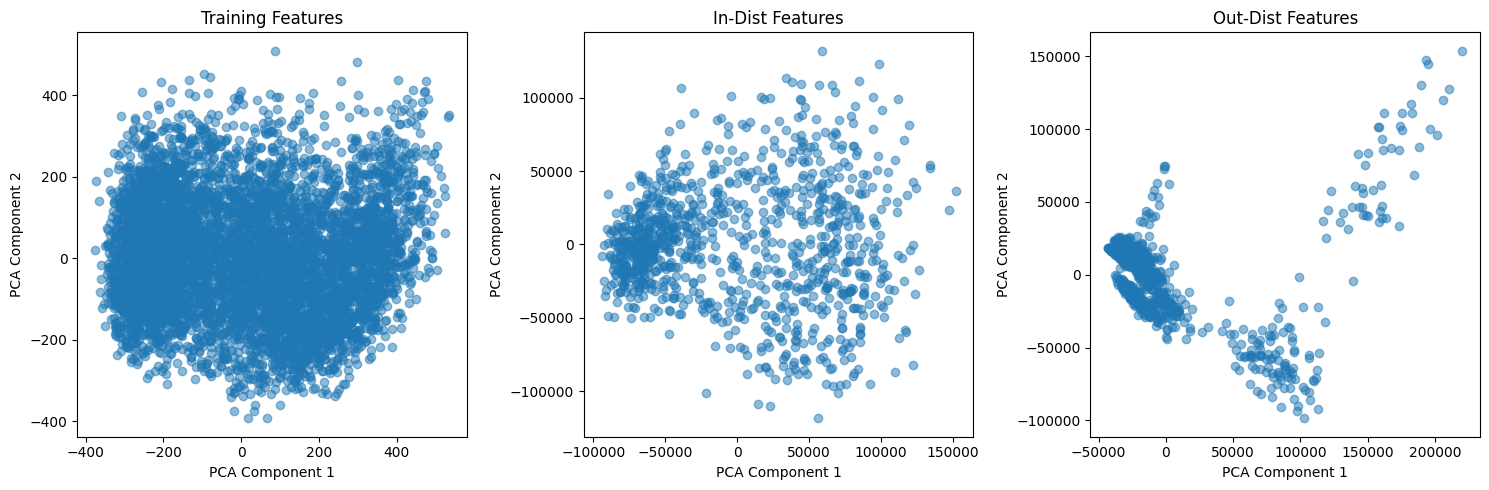

In [44]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Function to perform PCA and plot
def plot_pca(features, title, ax):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(features)
    ax.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each dataset
plot_pca(training_features, 'Training Features', axes[0])
plot_pca(in_dist_features, 'In-Dist Features', axes[1])
plot_pca(out_dist_features, 'Out-Dist Features', axes[2])

plt.tight_layout()
plt.show()


In [45]:
import numpy as np
from scipy.spatial import distance
from numpy.linalg import pinv

def compute_similarity(tr_features, tt_features, similarity_type='cosine'):
    """
    Compute similarities between training and testing features based on the specified type.

    Parameters:
    - tr_features (array): Training feature vectors.
    - tt_features (array): Testing feature vectors.
    - similarity_type (str): Type of similarity to compute ('cosine' or 'mahalanobis').

    Returns:
    - dict: Contains computed similarities and basic statistics.
    """

    def compute_cosine_similarity(tr_features_, tt_features_):
        centroid = np.mean(tr_features_, axis=0)
        return [1 - distance.cosine(feature, centroid) for feature in tt_features_]

    def compute_mahalanobis_similarity(tr_features_, tt_features_):
        covariance_matrix = np.cov(tr_features_, rowvar=False)
        covariance_matrix_inv = pinv(covariance_matrix)
        centroid = np.mean(tr_features_, axis=0)
        return [distance.mahalanobis(feature, centroid, covariance_matrix_inv) for feature in tt_features_]

    # Compute similarities
    if similarity_type == 'cosine':
        similarities = compute_cosine_similarity(tr_features, tt_features)
    elif similarity_type == 'mahalanobis':
        similarities = compute_mahalanobis_similarity(tr_features, tt_features)
    else:
        raise ValueError("Invalid similarity type. Choose 'cosine' or 'mahalanobis'.")

    # Compute statistics
    mean_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)
    median_similarity = np.median(similarities)
    mad_similarity = np.median(np.abs(similarities - median_similarity))
    percentile_95 = np.percentile(similarities, 95)
    percentile_99 = np.percentile(similarities, 99)
    range_similarity = np.ptp(similarities)
    iqr_similarity = np.percentile(similarities, 75) - np.percentile(similarities, 25)

    return {
        'similarities': similarities,
        'mean': mean_similarity,
        'std': std_similarity,
        'median': median_similarity,
        'mad': mad_similarity,
        'percentile_95': percentile_95,
        'percentile_99': percentile_99,
        'range': range_similarity,
        'iqr': iqr_similarity
    }



In [46]:

# Example usage:
# Assuming train_features, test_in_dist_features, and test_out_dist_features are defined
cosine_train_similarities_VGG16 = compute_similarity(training_features, training_features, "cosine")
cosine_train_similarities_actaul_VGG16 = cosine_train_similarities_VGG16['similarities']
cosine_mean_train_VGG16 = cosine_train_similarities_VGG16["mean"]
cosine_std_train_VGG16 = cosine_train_similarities_VGG16["std"]


# Computing the 3-sigma upper and lower control limits
cosine_3UCL_train_upper_VGG16 = cosine_mean_train_VGG16 + 3 * cosine_std_train_VGG16
cosine_3LCL_train_lower_VGG16 = cosine_mean_train_VGG16 - 3 * cosine_std_train_VGG16



cosine_in_dist_similarities_VGG16 = compute_similarity(training_features, in_dist_features, "cosine")
cosine_in_dist_similarities_VGG16_actual = cosine_in_dist_similarities_VGG16['similarities']

cosine_out_dist_similarities_VGG16 = compute_similarity(training_features, out_dist_features, "cosine")
cosine_out_dist_similarities_VGG16_actual = cosine_out_dist_similarities_VGG16['similarities']

cosine_in_dist_similarities_VGG16_mean = cosine_in_dist_similarities_VGG16["mean"]
cosine_in_dist_similarities_VGG16_std = cosine_in_dist_similarities_VGG16["std"]

cosine_out_dist_similarities_VGG16_mean = cosine_out_dist_similarities_VGG16["mean"]
cosine_out_dist_similarities_VGG16_std = cosine_out_dist_similarities_VGG16["std"]

print("Cosine - Mean train: {} | STD train: {}".format(cosine_mean_train_VGG16, cosine_std_train_VGG16))
print("Cosine - MEAN in-dist: {} | MEAN out-dist: {}".format(cosine_in_dist_similarities_VGG16_mean, cosine_in_dist_similarities_VGG16_std))
print("Cosine - STD out-dist: {} | STD out-dist: {}".format(cosine_out_dist_similarities_VGG16_mean, cosine_out_dist_similarities_VGG16_std))


Cosine - Mean train: 0.5925098968796454 | STD train: 0.07792199541964236
Cosine - MEAN in-dist: 0.5241942612826824 | MEAN out-dist: 0.06599918601346412
Cosine - STD out-dist: 0.14314031971818103 | STD out-dist: 0.028751455372233153


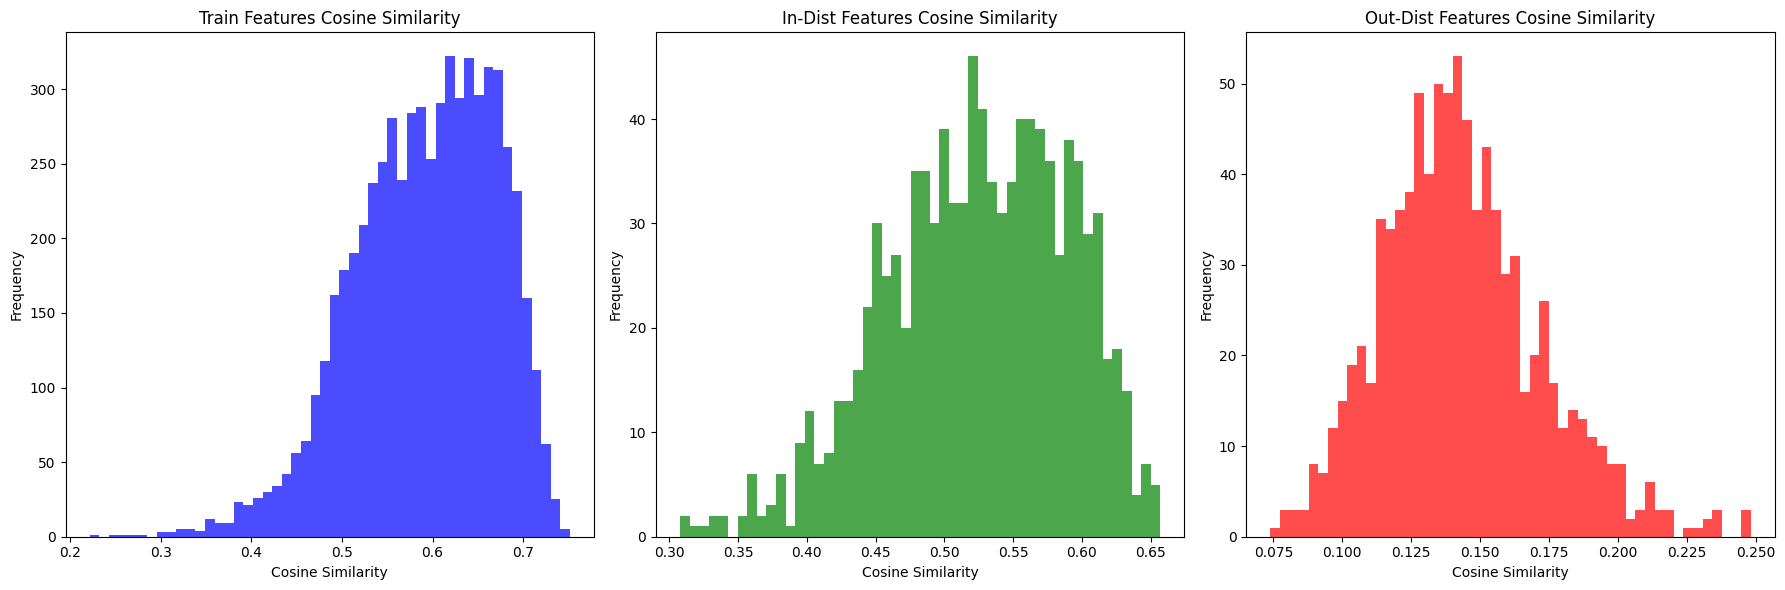

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(18, 6))

# Training Features Histogram
plt.subplot(1, 3, 1)
plt.hist(cosine_train_similarities_actaul_VGG16, bins=50, color='blue', alpha=0.7)
plt.title('Train Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# In-Dist Features Histogram
plt.subplot(1, 3, 2)
plt.hist(cosine_in_dist_similarities_VGG16_actual, bins=50, color='green', alpha=0.7)
plt.title('In-Dist Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Out-Dist Features Histogram
plt.subplot(1, 3, 3)
plt.hist(cosine_out_dist_similarities_VGG16_actual, bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Features Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



In [48]:
# Randomly pick 50 points from in-distribution and out-of-distribution cosine similarities
in_dist_samples = np.random.choice(cosine_in_dist_similarities_VGG16_actual, 50, replace=False)
out_dist_samples = np.random.choice(cosine_out_dist_similarities_VGG16_actual, 50, replace=False)

# Combine and shuffle these 100 points
combined_samples = np.concatenate((in_dist_samples, out_dist_samples))
# Also, create a label array to track InD (0) and OOD (1) points
labels = np.array([0]*50 + [1]*50)
# Shuffle both arrays in unison
shuffled_indices = np.random.permutation(np.arange(100))
combined_samples = combined_samples[shuffled_indices]
labels = labels[shuffled_indices]
#np.random.shuffle(combined_samples)
print(combined_samples)

# Identify points as in or out of distribution based on control limits
ood_predictions = [1 if val < cosine_3LCL_train_lower_VGG16 else 0 for val in combined_samples]

[0.45607698 0.44894254 0.55815017 0.60524511 0.14464252 0.1106535
 0.13423724 0.11038559 0.53063756 0.44607988 0.47507635 0.16641428
 0.14002302 0.47914582 0.14256424 0.44516915 0.50213963 0.10518975
 0.17013976 0.47519758 0.52095973 0.56315875 0.18996929 0.10122588
 0.43796679 0.42475146 0.1515168  0.15009946 0.14735951 0.3990263
 0.15411004 0.17404646 0.44923958 0.485789   0.12021028 0.57550538
 0.13789953 0.11578513 0.58333135 0.11846189 0.11301228 0.58388489
 0.13297859 0.42256302 0.59722763 0.12370766 0.12526996 0.17122422
 0.48424691 0.52818209 0.13751526 0.11584882 0.13150762 0.11743499
 0.57282865 0.1633424  0.14318679 0.17367427 0.50990987 0.13378334
 0.42303118 0.58518636 0.58302647 0.1456039  0.52915108 0.13722156
 0.46946788 0.4256092  0.10990011 0.54564226 0.13601002 0.5389297
 0.12396382 0.07389597 0.4528212  0.19248734 0.15457703 0.5207864
 0.54643083 0.57260048 0.15316677 0.54513836 0.50387871 0.50362134
 0.12004425 0.47731611 0.57534933 0.14796342 0.59030938 0.17384706

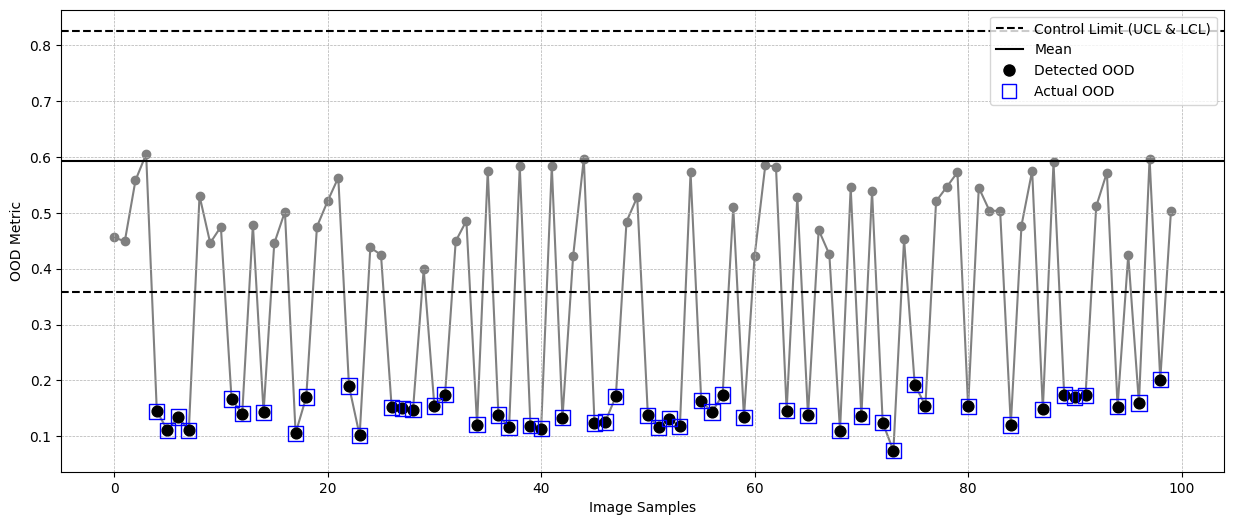

In [49]:
import matplotlib.pyplot as plt

# Assuming the following are defined:
# combined_samples - contains the mixed in-distribution and out-of-distribution points
# ood_predictions - flags for points detected as out-of-distribution based on control limits
# labels - actual labels indicating whether a point is in-distribution (0) or out-of-distribution (1)
# cosine_3UCL_train_upper, cosine_3LCL_train_lower - control limits
# cosine_mean_train - mean cosine similarity for the training set

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(combined_samples, marker='o', linestyle='-', color='grey', zorder=1)

# Plot control limits and mean
ax.axhline(np.clip(cosine_3UCL_train_upper_VGG16, a_min=0.0, a_max=1.0), color='k', linestyle='--', label='Control Limit (UCL & LCL)')
ax.axhline(np.clip(cosine_3LCL_train_lower_VGG16, a_min=0.0, a_max=1.0), color='k', linestyle='--')
ax.axhline(cosine_mean_train_VGG16, color='k', linestyle='-', label='Mean')

# Highlight points detected as out-of-distribution with black stars
for i, val in enumerate(combined_samples):
    if ood_predictions[i] == 1:
        ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)

# Circle actual out-of-distribution points with blue circles
for i, val in enumerate(combined_samples):
    if labels[i] == 1:
        ax.scatter(i, val, marker='s', facecolors='none', edgecolors='blue', s=120, zorder=3)

# Set chart properties
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Update the legend
legend_elements = [plt.Line2D([0], [0], color='k', linestyle='--', label='Control Limit (UCL & LCL)'),
                   plt.Line2D([0], [0], color='k', linestyle='-', label='Mean'),
                   plt.Line2D([0], [0], marker='o', color='w', label='Detected OOD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Actual OOD', markerfacecolor='none', markeredgecolor='blue', markersize=10)]
ax.legend(handles=legend_elements)

# Set chart properties (adding the axis labels here)
ax.set_xlabel('Image Samples')  # X-axis label
ax.set_ylabel('OOD Metric')    # Y-axis label
ax.set_facecolor('white')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
# Show the plot
plt.show()


In [50]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.utils import resample

# Combine the cosine similarity scores and their corresponding labels
combined_scores = np.concatenate([cosine_in_dist_similarities_VGG16_actual, cosine_out_dist_similarities_VGG16_actual])
# Label: 1 for out-of-distribution, 0 for in-distribution
combined_labels = np.concatenate([np.zeros(len(cosine_in_dist_similarities_VGG16_actual)), np.ones(len(cosine_out_dist_similarities_VGG16_actual))])

# Apply the rule to flag points
ood_predictions = np.array([1 if val < cosine_3LCL_train_lower_VGG16 else 0 for val in combined_scores])

# Function to compute metrics
def compute_metrics(y_true, y_pred):
    sensitivity = recall_score(y_true, y_pred)  # Same as recall
    specificity = recall_score(y_true, y_pred, pos_label=0)
    accuracy = accuracy_score(y_true, y_pred)
    return sensitivity, specificity, accuracy

# Compute initial metrics
initial_sensitivity, initial_specificity, initial_accuracy = compute_metrics(combined_labels, ood_predictions)

# Bootstrapping for confidence intervals
n_iterations = 1000
n_size = int(len(combined_labels) * 0.5)  # 50% sample size
bootstrapped_metrics = []

for _ in range(n_iterations):
    # Prepare bootstrap sample
    indices = resample(np.arange(len(combined_labels)), n_samples=n_size)
    boot_labels = combined_labels[indices]
    boot_predictions = ood_predictions[indices]

    # Compute metrics
    metrics = compute_metrics(boot_labels, boot_predictions)
    bootstrapped_metrics.append(metrics)

# Convert to numpy array for easy percentile computation
bootstrapped_metrics = np.array(bootstrapped_metrics)

# Compute 95% confidence intervals
lower_p = 2.5
upper_p = 97.5
sensitivity_conf = np.percentile(bootstrapped_metrics[:, 0], [lower_p, upper_p])
specificity_conf = np.percentile(bootstrapped_metrics[:, 1], [lower_p, upper_p])
accuracy_conf = np.percentile(bootstrapped_metrics[:, 2], [lower_p, upper_p])

print("Supervised features (initial_sensitivity)", initial_sensitivity)
print("Supervised features (sensitivity_conf)", sensitivity_conf)

print("Ssupervised features (initial_specificity)", initial_specificity)
print("Supervised features (specificity_conf)", specificity_conf)

print("Ssupervised features (initial_accuracy)", initial_accuracy)
print("Supervised features (accuracy_conf)", accuracy_conf)

#initial_sensitivity, initial_specificity, initial_accuracy, sensitivity_conf, specificity_conf, accuracy_conf


Unsupervised features (initial_sensitivity) 1.0
Unsupervised features (sensitivity_conf) [1. 1.]
Unsupervised features (initial_specificity) 0.99
Unsupervised features (specificity_conf) [0.98050203 0.99796334]
Unsupervised features (initial_accuracy) 0.9947257383966245
Unsupervised features (accuracy_conf) [0.98945148 0.99894515]


We will start by randomly selecting out-dist and in-dist and applying three charts: three-sigma, Bernouuli CUSUM, and CUSM to each samples.

In [51]:
# Now, I want to 60 images and use these samples to create the follwoing charts:
# Three-sigma chart, Bernouuli CUSUM, CUSUM

# Take 30 random samples without replacement from each
in_dist_samples = np.random.choice(cosine_in_dist_similarities_VGG16_actual, 30, replace=False)
out_dist_samples = np.random.choice(cosine_out_dist_similarities_VGG16_actual, 30, replace=False)

# Combine the two sets of samples into one vector
combined_in_out_samples = np.concatenate((in_dist_samples, out_dist_samples))
print(combined_samples)

[0.45607698 0.44894254 0.55815017 0.60524511 0.14464252 0.1106535
 0.13423724 0.11038559 0.53063756 0.44607988 0.47507635 0.16641428
 0.14002302 0.47914582 0.14256424 0.44516915 0.50213963 0.10518975
 0.17013976 0.47519758 0.52095973 0.56315875 0.18996929 0.10122588
 0.43796679 0.42475146 0.1515168  0.15009946 0.14735951 0.3990263
 0.15411004 0.17404646 0.44923958 0.485789   0.12021028 0.57550538
 0.13789953 0.11578513 0.58333135 0.11846189 0.11301228 0.58388489
 0.13297859 0.42256302 0.59722763 0.12370766 0.12526996 0.17122422
 0.48424691 0.52818209 0.13751526 0.11584882 0.13150762 0.11743499
 0.57282865 0.1633424  0.14318679 0.17367427 0.50990987 0.13378334
 0.42303118 0.58518636 0.58302647 0.1456039  0.52915108 0.13722156
 0.46946788 0.4256092  0.10990011 0.54564226 0.13601002 0.5389297
 0.12396382 0.07389597 0.4528212  0.19248734 0.15457703 0.5207864
 0.54643083 0.57260048 0.15316677 0.54513836 0.50387871 0.50362134
 0.12004425 0.47731611 0.57534933 0.14796342 0.59030938 0.17384706

In [52]:
shift_start_day = 30  # The point at which the shift occurs
mu0_in_control = np.mean(combined_in_out_samples[:shift_start_day])  # Mean of the in-control data
std0_in_control = np.std(combined_in_out_samples[:shift_start_day])  # Standard deviation of the in-control data
print(mu0_in_control)
print(std0_in_control)

0.5362737079461416
0.06548164628415754


## The first implementation is for SPC (three-sigma) for image by image

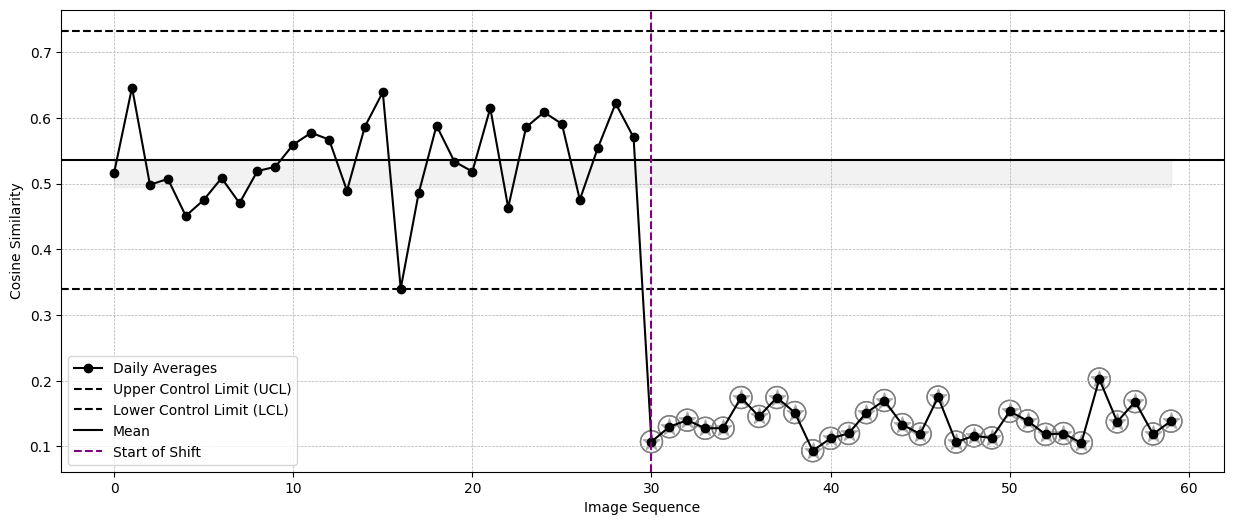

Confusion Matrix:
[[30  0]
 [ 0 30]]

Accuracy: 100.00%
Recall: 100.00%
Precision: 100.00%
F1 Score: 1.00


In [54]:
# Define the control limits using the three-sigma rule
upper_control_limit_VGG = mu0_in_control + 3 * std0_in_control
lower_control_limit_VGG = mu0_in_control - 3 * std0_in_control


# Function to create the first vector
def create_control_vector(samples, upper_control_limit_VGG, lower_control_limit_VGG):
    return [1 if val > upper_control_limit_VGG or val < lower_control_limit_VGG else 0 for val in samples]

# Function to create the second vector
def create_shift_vector(length, shift_start):
    return [0 if i < shift_start else 1 for i in range(length)]

# Create the binary vectors
binary_3sigma_vector = create_control_vector(combined_in_out_samples, upper_control_limit_VGG, lower_control_limit_VGG)
ground_truth_vector = create_shift_vector(len(combined_in_out_samples), shift_start_day)

#print(len(control_vector))
#print(ground_truth_vector)

#print(len(shift_vector))
#print(ground_truth_vector)

# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(combined_in_out_samples, marker='o', linestyle='-', color='k', label='Daily Averages')  # Black color for plot

# Plot control limits and mean
ax.axhline(upper_control_limit_VGG, color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(lower_control_limit_VGG, color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(mu0_in_control, color='k', linestyle='-', label='Mean')  # Black color for mean
plt.fill_between(range(len(combined_in_out_samples)), \
                    np.clip(lower_control_limit, a_min=0.0, a_max=1.0), \
                    np.clip(upper_control_limit, a_min=0.0, a_max=1.0), \
                    color='grey', alpha=0.1)


# Highlight points outside of control limits with grey circle around them
for i, val in enumerate(combined_in_out_samples):
    if val > upper_control_limit_VGG or val < lower_control_limit_VGG:
        ax.scatter(i, val, color='darkgrey', marker='*', s=150)  # Dark grey stars for out-of-control points
        ax.scatter(i, val, facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around out-of-control points


# Circle all points after the shift point
for i in range(shift_start_day, len(combined_in_out_samples)):
    ax.scatter(i, combined_in_out_samples[i], facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around points after shift


# Indicate the start of the shift
ax.axvline(x=shift_start_day, color='purple', linestyle='--', label='Start of Shift')  # Purple line for shift start

ax.set_facecolor('white')  # White background
ax.set_xlabel('Image Sequence')
ax.set_ylabel('Cosine Similarity')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
plt.show()

from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report, f1_score

# Calculate the confusion matrix
conf_matrix = confusion_matrix(binary_3sigma_vector, ground_truth_vector)

# Calculate accuracy, recall, precision, and F1 score
accuracy = accuracy_score(binary_3sigma_vector, ground_truth_vector)
recall = recall_score(binary_3sigma_vector, ground_truth_vector)
precision = precision_score(binary_3sigma_vector, ground_truth_vector)
f1 = f1_score(binary_3sigma_vector, ground_truth_vector)

# Print the metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("F1 Score: {:.2f}".format(f1))


In [55]:
# Select CUSUM paramters

# Initialize lists to store results
FalsePos = []
TruePos = []
AvgDD = []  # Average Detection Delay
DetectionTimes = []

# Define the range of k values as a fraction of in_std
k_values = [0.1, 0.25, 0.5, 0.75, 1.0]

# Specify the control parameters and the threshold
pre_change_days = 30  # Number of days the process is in-control
total_days = 60  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
delta = 1  # Change magnitude in terms of standard deviations

# Split your data into in-control and out-of-control periods
in_control_sp = combined_in_out_samples[:pre_change_days]
out_control_sp = combined_in_out_samples[pre_change_days:total_days]

# Compute the mean and standard deviation for in-control and out-of-control periods
mu_in = np.mean(in_control_sp)
mu_out = np.mean(out_control_sp)
in_std = np.std(in_control_sp)

#k = (delta * in_std) / 2
print(len(combined_in_out_samples))
print(mu_in)
print(mu_out)

60
0.5362737079461416
0.13632708912094435


In [56]:
# This function creates a daily pool of in-dist and out-dist test set based on the decided percentage of shift

# Define the number of days and distances per day
total_days = 60
distances_per_day = 100

# Create an empty list to store daily data
all_data = []

# Function to select data for each day
def select_daily_data(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    # Randomly select out-of-distribution and in-distribution data
    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    # Combine and return the daily data
    return np.concatenate([daily_out_dist_data, daily_in_dist_data])

 # Simulate data for each day. This case is a small shift
for day in range(1, total_days + 1):
    if day <= 30:
        percent_out_dist = 2  # First month: pre shift
    elif day <= 60:
        percent_out_dist = 5  # First Shift: 4% OOD
    # elif day <= 70:
    #    percent_out_dist = 7 # Second Shift: 7% OOD
    # elif day <= 100:
    #    percent_out_dist = 12  # Third Shift: 12% OOD
    #elif day <= 150:
    #    percent_out_dist = 10 # Third month: 28% OOD
    #else:
    #    percent_out_dist = 5 # Fourth month: 7% OOD

    daily_data = select_daily_data(
        cosine_in_dist_similarities_VGG16_actual,
        cosine_out_dist_similarities_VGG16_actual,
        percent_out_dist,
        distances_per_day
    )
    all_data.append(daily_data)


# Combine all daily data for CUSUM analysis
avg_cusum_data = np.concatenate(all_data)
print(len(avg_cusum_data))

# This output can be used by 2-sigma and 3-sigma chart, as we are only using one value with them.

6000


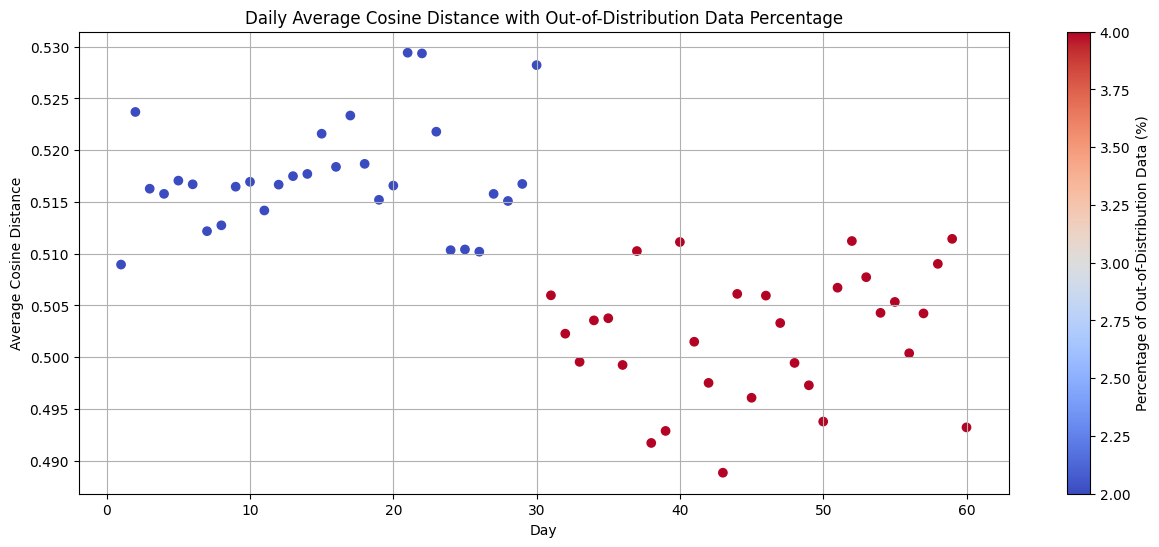

60


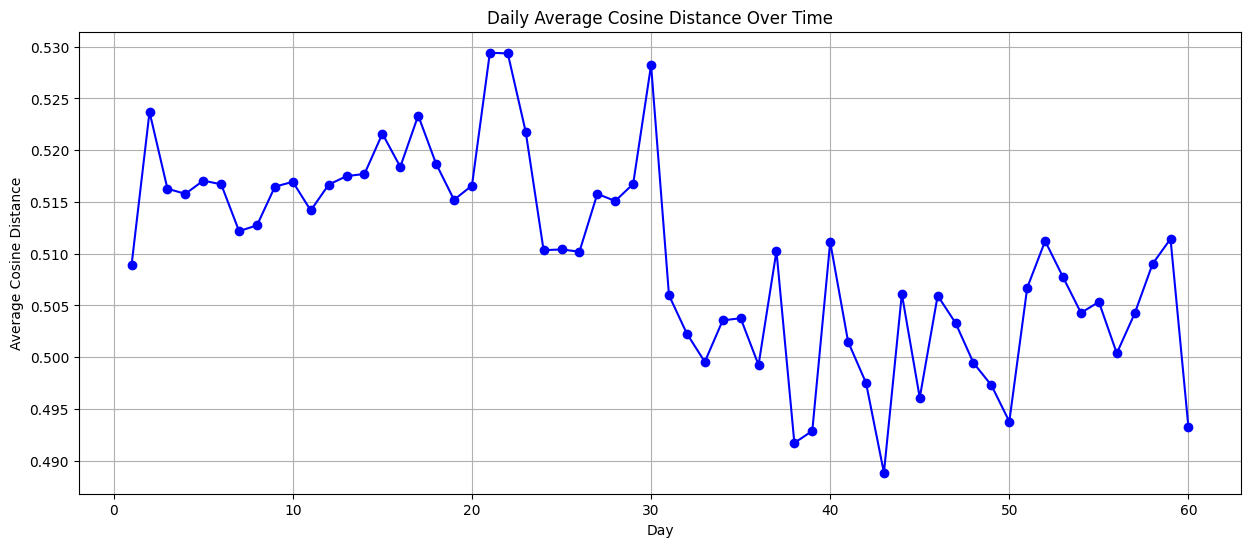

In [57]:
# The previous function uses single images for 2-sigma and 3-sigma charts
# For CUSUM, we will use the average per day

# Calculate the daily averages and the percentage of out-of-distribution data
daily_averages = [np.mean(day) for day in all_data]
percentages_out_dist = []

for day in range(1, total_days + 1):
      if day <= 30:
        percent_out_dist = 2  # First month: 3% OOD
      elif day <= 60:
        percent_out_dist = 4  # Second month: 4% OOD
      #elif day <= 70:
      #  percent_out_dist = 7 # Third month: 7% OOD
      #elif day <= 100:
      #  percent_out_dist = 5  # Third month: 12% OOD
      #elif day <= 150:
      #  percent_out_dist = 10 # Third montn: 28% OOD
      #else:
      #  percent_out_dist = 5 # Fourth month: 7% OOD
      percentages_out_dist.append(percent_out_dist)

# Plotting
plt.figure(figsize=(15, 6))
sc = plt.scatter(range(1, total_days + 1), daily_averages, c=percentages_out_dist, cmap='coolwarm')
plt.colorbar(sc, label='Percentage of Out-of-Distribution Data (%)')
plt.title('Daily Average Cosine Distance with Out-of-Distribution Data Percentage')
plt.xlabel('Day')
plt.ylabel('Average Cosine Distance')
plt.grid(True)
plt.show()


# Calculate the daily averages
daily_averages = [np.mean(day) for day in all_data]
CUSUM_data_average_day = np.array(daily_averages)
print(len(CUSUM_data_average_day))

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(range(1, total_days + 1), daily_averages, marker='o', linestyle='-', color='b')
plt.title('Daily Average Cosine Distance Over Time')
plt.xlabel('Day')
plt.ylabel('Average Cosine Distance')
plt.grid(True)
plt.show()

# Now daily_averages can be used for further analysis like CUSUM
#daily_averages[:60]  # Displaying the first 10 days as a sample
#print(len(daily_averages))
#print(np.mean(daily_averages[1:15]) )
#print(np.mean(daily_averages[16:30]) )


# Save the cosine similarity for each batch for each day.
np.savetxt("/content/drive/My Drive/daily_averages_cosine_CUSUM_VGG16.csv", daily_averages, delimiter=",", fmt='%s')



In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the function `select_daily_data_with_labels` is already defined as earlier
# Let's redefine it here for completeness
def select_daily_data_with_labels(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    daily_out_dist_labels = ['out-dist'] * out_dist_count
    daily_in_dist_labels = ['in-dist'] * in_dist_count

    combined_data = np.concatenate((daily_in_dist_data, daily_out_dist_data))
    combined_labels = np.concatenate((daily_in_dist_labels, daily_out_dist_labels))

    combined = list(zip(combined_data, combined_labels))
    np.random.shuffle(combined)

    shuffled_data, shuffled_labels = zip(*combined)
    return list(shuffled_data), list(shuffled_labels)

# Assuming cosine_in_dist_similarities and cosine_out_dist_similarities are already defined
# as arrays of cosine similarity values for in-distribution and out-of-distribution data

# Now we select the data for the four days
day_data = {}
day_labels = {}
# percentages_out_dist = [3, 4, 7, 12]  # Percentage for each period
percentages_out_dist = [5, 12]  # Percentage for each period


# Select one day before day 30
day_data[1], day_labels[1] = select_daily_data_with_labels(
    cosine_in_dist_similarities_VGG16_actual,
    cosine_out_dist_similarities_VGG16_actual,
    percentages_out_dist[0],  # 3% out-dist
    100
)

# Select one day between day 31 and day 60
day_data[2], day_labels[2] = select_daily_data_with_labels(
    cosine_in_dist_similarities_VGG16_actual,
    cosine_out_dist_similarities_VGG16_actual,
    percentages_out_dist[1],  # 4% out-dist
    100
)

# Select one day between day 41 and day 69
# day_data[3], day_labels[3] = select_daily_data_with_labels(
#    cosine_in_dist_similarities,
#    cosine_out_dist_similarities,
#    percentages_out_dist[2],  # 7% out-dist
#    60
#)

# Select one day between day 71 and day 99
#day_data[4], day_labels[4] = select_daily_data_with_labels(
#    cosine_in_dist_similarities,
#    cosine_out_dist_similarities,
#    percentages_out_dist[3],  # 12% out-dist
#    60
#)

# Now day_data contains the cosine similarities for the selected days
# and day_labels contains the corresponding labels

# We can now print the cosine similarities for each selected day
for day in day_data:
    print(f"Day {day} Data:")
    print(day_data[day])
    print(f"Day {day} Labels:")
    print(day_labels[day])
    print("\n")  # Print a newline for better readability between days


#day_labels = {
#    1: ['in-dist'] * 58 + ['out-dist'] * 2,
#    2: ['in-dist'] * 57 + ['out-dist'] * 3,
#    #3: ['in-dist'] * 56 + ['out-dist'] * 4,
    #4: ['in-dist'] * 53 + ['out-dist'] * 7
#}


# Percentages of out-of-distribution data for each day
percentages_out_dist = [5, 12]  # Extend this list as needed for more days

day_labels = {}

for day, out_dist_percentage in enumerate(percentages_out_dist, start=1):
    total_data_count = 100  # Assuming each day has 100 data points
    out_dist_count = int(total_data_count * out_dist_percentage / 100)
    in_dist_count = total_data_count - out_dist_count

    day_labels[day] = ['in-dist'] * in_dist_count + ['out-dist'] * out_dist_count

# Now day_labels contains dynamically assigned labels based on percentages

# Example: Print labels for each day
for day, labels in day_labels.items():
    print(f"Day {day} Labels:")
    print(labels)
    print("\n")

# Now we'll count the number of in-dist and out-dist points for each day.
in_dist_count = {}
out_dist_count = {}

for day, labels in day_labels.items():
    in_dist_count[day] = labels.count('in-dist')
    out_dist_count[day] = labels.count('out-dist')

in_dist_count, out_dist_count

Day 1 Data:
[0.4928431808948517, 0.5370401740074158, 0.42902109026908875, 0.42303118109703064, 0.5806092023849487, 0.6044731140136719, 0.6068050265312195, 0.48140713572502136, 0.6338128447532654, 0.5369383096694946, 0.562343180179596, 0.6064938306808472, 0.5915883779525757, 0.5021630525588989, 0.5266904830932617, 0.5594155788421631, 0.5291510820388794, 0.5243974924087524, 0.5077167749404907, 0.5737578272819519, 0.5175134539604187, 0.4503048360347748, 0.1361735761165619, 0.4776814579963684, 0.5393568873405457, 0.5695254802703857, 0.4914346933364868, 0.4967081546783447, 0.5659013390541077, 0.5838848948478699, 0.411006897687912, 0.5861771106719971, 0.5184069871902466, 0.4777490496635437, 0.5910130143165588, 0.575385332107544, 0.3991277813911438, 0.4457519054412842, 0.5704323649406433, 0.4981257915496826, 0.4247514605522156, 0.499991774559021, 0.5320349931716919, 0.6179656386375427, 0.5545638799667358, 0.4738079011440277, 0.4492577612400055, 0.5753733515739441, 0.5589068531990051, 0.452923

({1: 95, 2: 88}, {1: 5, 2: 12})

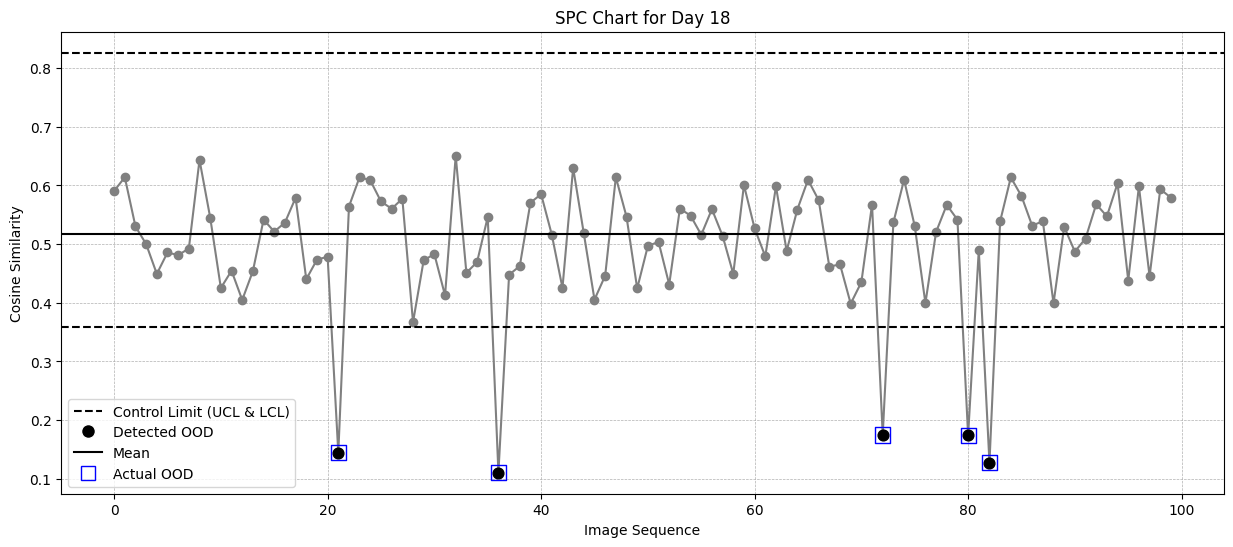

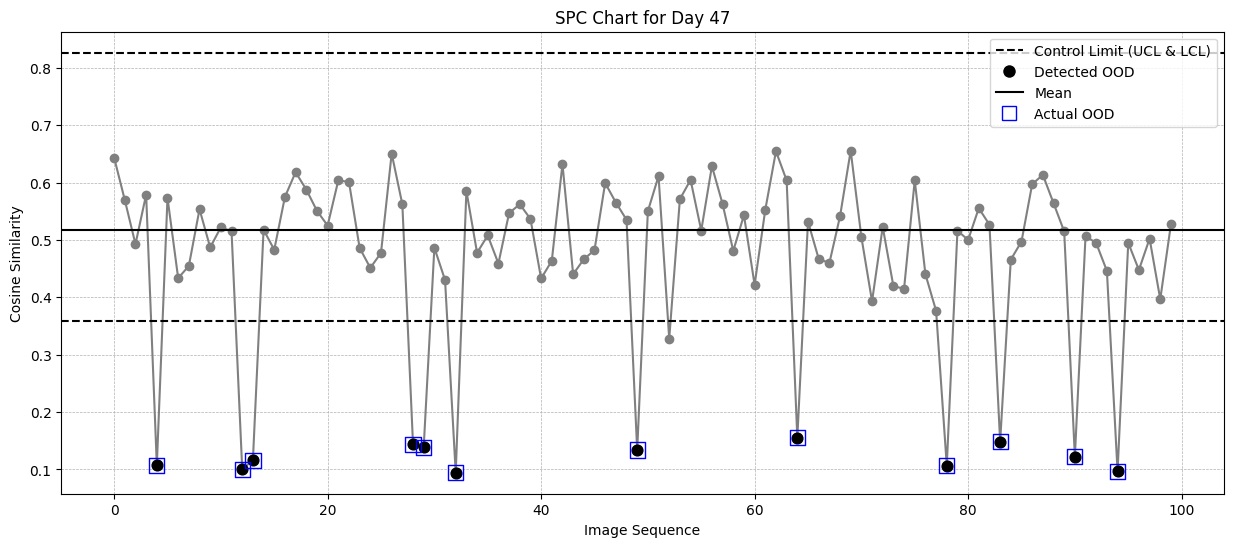

In [68]:
# sample_days = [15, 35, 65, 95]
sample_days = [18, 47]


# Calculate the mean and standard deviation for in-distribution data
mean_in_dist_day_bacth = np.mean(cosine_train_similarities_actaul_VGG16)
std_in_dist_day_batch = np.std(cosine_train_similarities_actaul_VGG16)

# Define the control limits using the three-sigma rule for in-distribution data
upper_control_limit = mean_in_dist_day_bacth + 3 * std_in_dist_day_batch
lower_control_limit = mean_in_dist_day_bacth - 3 * std_in_dist_day_batch


# Define the function to select daily data with labels
def select_daily_data_with_labels(in_dist_data, out_dist_data, out_dist_percent, day_data_count):
    out_dist_count = int(day_data_count * out_dist_percent / 100)
    in_dist_count = day_data_count - out_dist_count

    daily_out_dist_data = np.random.choice(out_dist_data, out_dist_count, replace=False)
    daily_in_dist_data = np.random.choice(in_dist_data, in_dist_count, replace=False)

    daily_out_dist_labels = ['out-dist'] * out_dist_count
    daily_in_dist_labels = ['in-dist'] * in_dist_count

    combined_data = np.concatenate((daily_in_dist_data, daily_out_dist_data))
    combined_labels = np.concatenate((daily_in_dist_labels, daily_out_dist_labels))

    combined = list(zip(combined_data, combined_labels))
    np.random.shuffle(combined)

    shuffled_data, shuffled_labels = zip(*combined)
    return list(shuffled_data), list(shuffled_labels)

# Now we select the data for the four days with the specified out-of-distribution percentages
# percentages_out_dist = [3, 4, 7, 12]  # Percentage for each period
percentages_out_dist = [5,12]  # Percentage for each period
day_data = {}
day_labels = {}

for i, percent_out_dist in enumerate(percentages_out_dist, start=1):
    day_data[i], day_labels[i] = select_daily_data_with_labels(
        cosine_in_dist_similarities_VGG16_actual,
        cosine_out_dist_similarities_VGG16_actual,
        percent_out_dist,
        100
    )

# Let's create a function to plot SPC chart for given day
def plot_spc_chart(day_data, day_labels, upper_control_limit, lower_control_limit, day_number):
    # Plot the SPC chart
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(day_data, marker='o', linestyle='-', color='grey', label=f' {day_number} Data')  # Black color for plot

    # Plot control limits and mean
    ax.axhline(upper_control_limit, color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
    ax.axhline(lower_control_limit, color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
    ax.axhline(np.mean(daily_averages[1:20]), color='k', linestyle='-', label='Mean')  # Black color for mean


    # Highlight out-of-distribution points
    for i, (val, label) in enumerate(zip(day_data, day_labels)):
        if label == 'out-dist':
            ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)  # Red circles for out-of-control points
    # Highlight out-of-distribution points and draw a circle around them as known ground truth
    for i, (val, label) in enumerate(zip(day_data, day_labels)):
        if label == 'out-dist':
            #ax.scatter(i, val, color='grey', marker='o', s=250)  # Red circles for known out-of-control points
            ax.scatter(i, val, facecolors='none', edgecolors='blue', marker='s', s=120, zorder=3)  # Circle around the point



    # Update the legend
    legend_elements = [plt.Line2D([0], [0], color='k', linestyle='--', label='Control Limit (UCL & LCL)'),
                       plt.Line2D([0], [0], marker='o', color='w', label='Detected OOD', markerfacecolor='black', markersize=10),
                       plt.Line2D([0], [0], color='k', linestyle='-', label='Mean'),
                       plt.Line2D([0], [0], marker='s', color='w', label='Actual OOD', markerfacecolor='none', markeredgecolor='blue', markersize=10)]
    ax.legend(handles=legend_elements)

    ax.set_facecolor('white')  # White background
    ax.set_title(f'SPC Chart for {day_number}')
    ax.set_xlabel('Image Sequence')
    ax.set_ylabel('Cosine Similarity')
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility


    plt.show()



# Now we plot the SPC charts with "Day 15", "Day 35", "Day 65", and "Day 95" as titles
for day, day_number in enumerate(sample_days, start=1):
  day_title = f'Day {day_number}'  # Create a title string for the chart
  plot_spc_chart(day_data[day], day_labels[day], upper_control_limit, lower_control_limit, day_title)


0.5177632052477064
0.5019937126621091


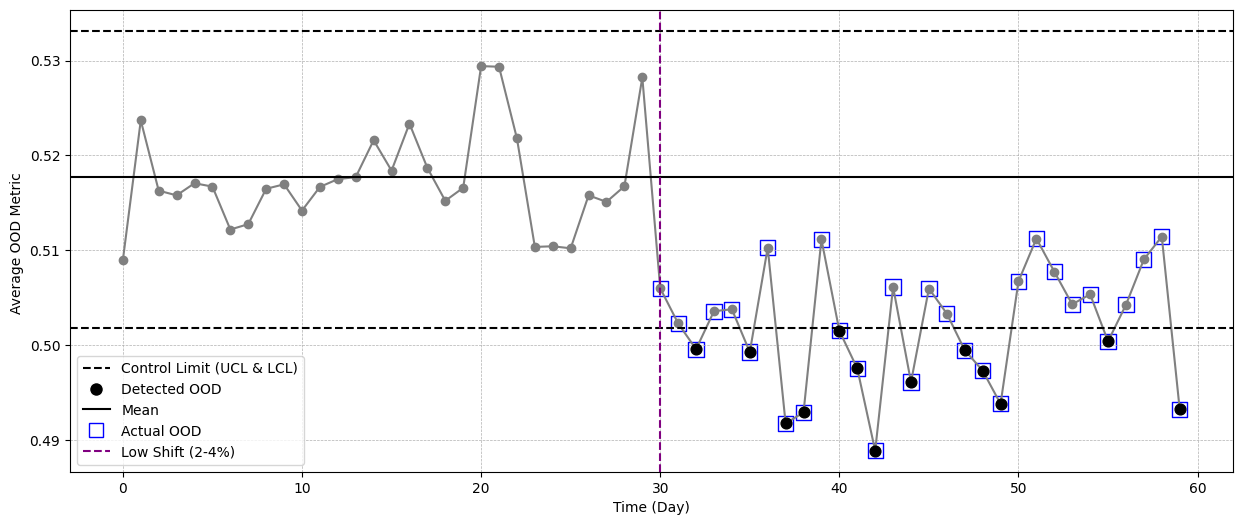

In [81]:
# Three sigma chart for the average vaue
# Define the control limits using the three-sigma rule
upper_control_limit = np.mean(daily_averages[:30]) + 3 * np.std(daily_averages[:30])
lower_control_limit = np.mean(daily_averages[:30]) - 3 * np.std(daily_averages[:30])

print(np.mean(daily_averages[1:30]))
print(np.mean(daily_averages[31:60]))

shift_start_day = 31
#print(upper_control_limit)
#print(lower_control_limit)

# Create Bernoulli CUSUM vectors
average_binary_3sigma_vector = create_control_vector(daily_averages, upper_control_limit, lower_control_limit)
average_ground_truth_vector = create_shift_vector(len(daily_averages), shift_start_day)


# Plot the SPC chart
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(daily_averages, marker='o', linestyle='-', color='grey', label='Daily Averages')  # Black color for plot

# Plot control limits and mean
ax.axhline(upper_control_limit, color='k', linestyle='--', label='Upper Control Limit (UCL)')  # Black color for UCL
ax.axhline(lower_control_limit, color='k', linestyle='--', label='Lower Control Limit (LCL)')  # Black color for LCL
ax.axhline(np.mean(daily_averages[1:30]), color='k', linestyle='-', label='Mean')  # Black color for mean


# Highlight points outside of control limits with grey circle around them
for i, val in enumerate(daily_averages):
    if val > upper_control_limit or val < lower_control_limit:
        ax.scatter(i, val, color='black', marker='o', s=60, zorder=2)  # Dark grey stars for out-of-control points
        #ax.scatter(i, val, facecolors='none', edgecolors='grey', marker='o', s=250)  # Grey circle around out-of-control points

# Circle all points after the shift point
for i in range(30, len(daily_averages)):
    ax.scatter(i, daily_averages[i], facecolors='none', edgecolors='blue', marker='s', s=120)  # Grey circle around points after shift



# Indicate the first shift point
ax.axvline(x=30, color='purple', linestyle='--', label='Low Shift (2-4%)')  # Purple line for shift start
# Indicate the second shift point
#ax.axvline(x=40, color='purple', linestyle='--', label='Second Shift (moderate)')  # Purple line for shift start
# Indicate the third shift point
#ax.axvline(x=70, color='purple', linestyle='--', label='Third Shift (high)')  # Purple line for shift start

ax.set_facecolor('white')  # White background
ax.set_xlabel('Time (Day)')
ax.set_ylabel('Average OOD Metric ')




    # Update the legend
legend_elements = [plt.Line2D([0], [0], color='k', linestyle='--', label='Control Limit (UCL & LCL)'),
                   plt.Line2D([0], [0], marker='o', color='w', label='Detected OOD', markerfacecolor='black', markersize=10),
                   plt.Line2D([0], [0], color='k', linestyle='-', label='Mean'),
                   plt.Line2D([0], [0], marker='s', color='w', label='Actual OOD', markerfacecolor='none', markeredgecolor='blue', markersize=10),
                   plt.Line2D([0], [0], color='purple', linestyle='--', label='Low Shift (2-4%)')]
ax.legend(handles=legend_elements)

#ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)  # Lighter grid lines for better visibility

# Show the plot
plt.show()


In [82]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(average_ground_truth_vector, average_binary_3sigma_vector)

# Calculate True Positive (TP), False Positive (FP), True Negative (TN), and False Negative (FN)
TP, FP, FN, TN = conf_matrix.ravel()

# Calculate accuracy, sensitivity (recall), and specificity
accuracy = accuracy_score(average_ground_truth_vector, average_binary_3sigma_vector)
sensitivity = TP / (TP + FN)  # Recall
specificity = TN / (TN + FP)

# Print the metrics
print("Confusion Matrix:")
print(conf_matrix)

print("\nAccuracy: {:.2f}%".format(accuracy * 100))
print("Sensitivity (Recall): {:.2f}%".format(sensitivity * 100))
print("Specificity: {:.2f}%".format(specificity * 100))



Confusion Matrix:
[[31  0]
 [16 13]]

Accuracy: 73.33%
Sensitivity (Recall): 65.96%
Specificity: 100.00%


CUSUM: One image VS. Average

In [83]:
# Define CUSUM function
def CUSUM(x, mu0, k, h):
    S_hi = [0]
    S_lo = [0]
    for i in range(len(x)):
        S_hi.append(max(0, S_hi[i] + (x[i] - mu0 - k)))
        S_lo.append(min(0, S_lo[i] + (x[i] - mu0 + k)))

    S_hi = np.array(S_hi[1:])
    S_lo = np.array(S_lo[1:])

    signal_hi = np.where(S_hi > h)[0]
    signal_lo = np.where(S_lo < -h)[0]
    signal = np.unique(np.concatenate((signal_hi, signal_lo)))

    return signal, S_hi, S_lo

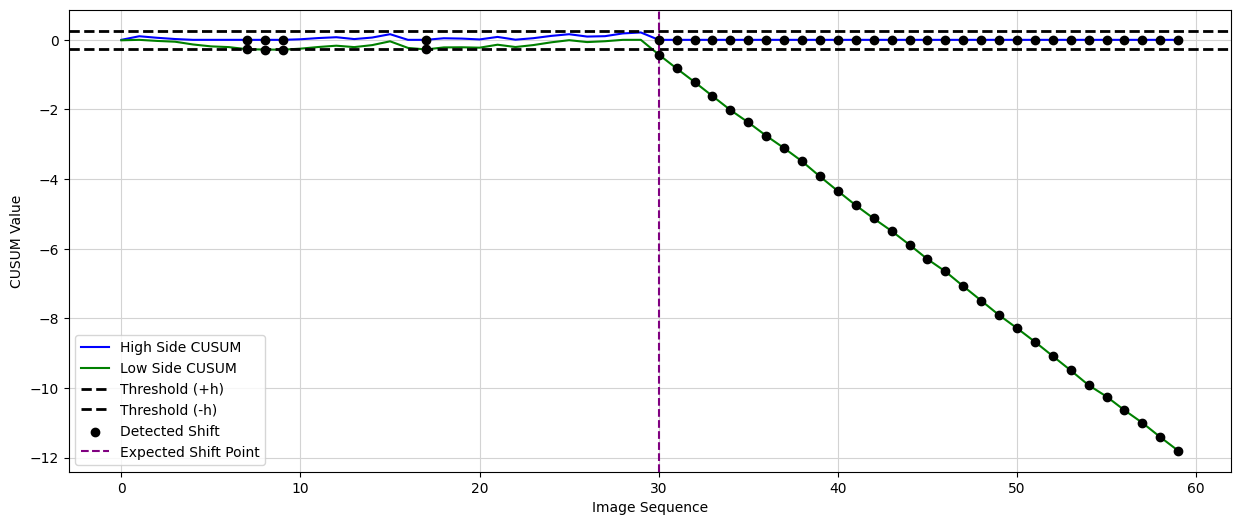

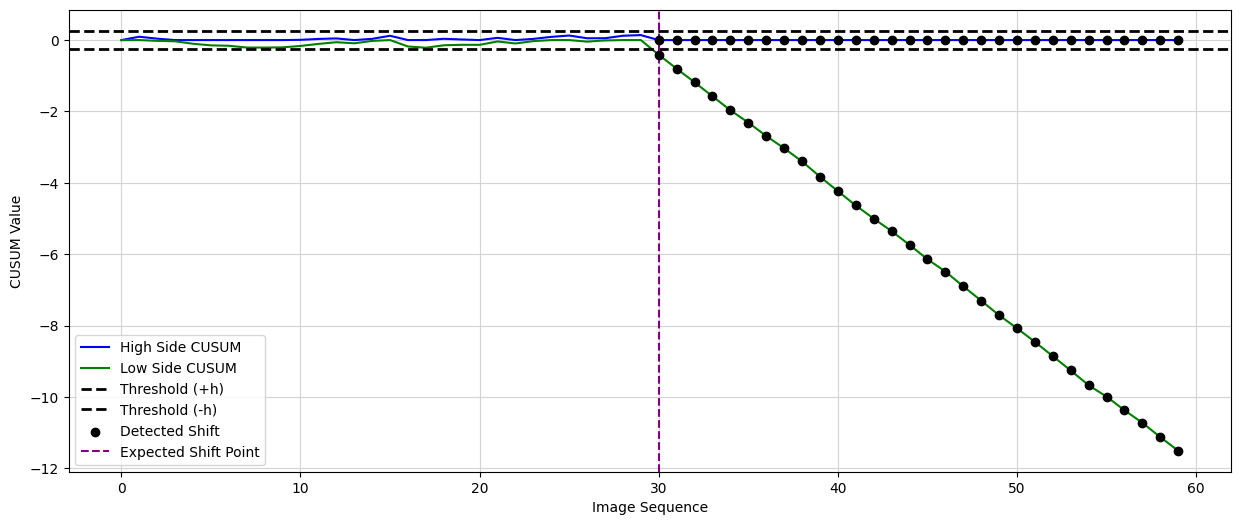

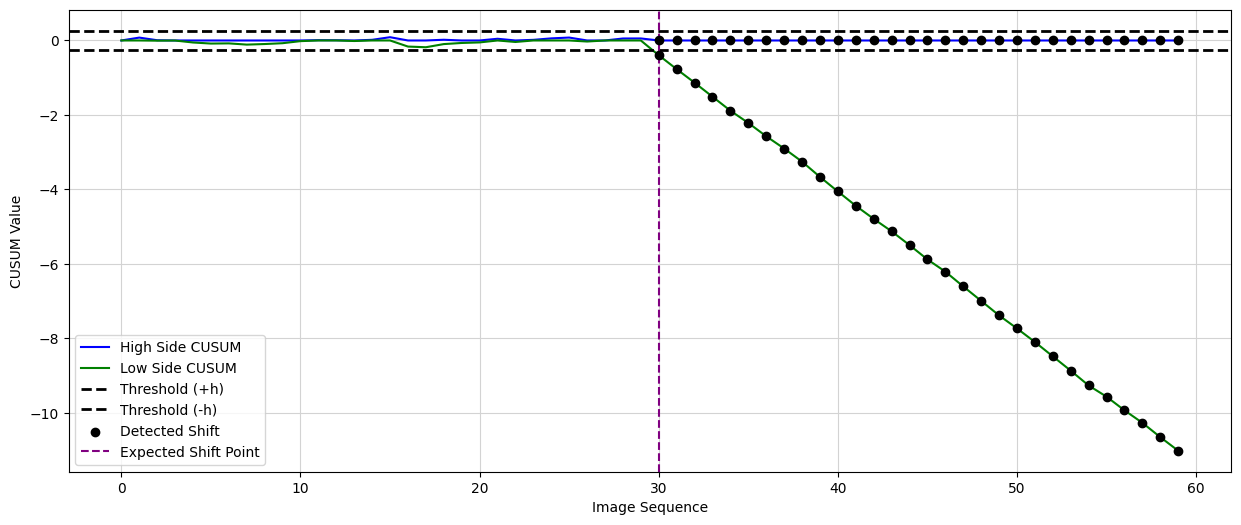

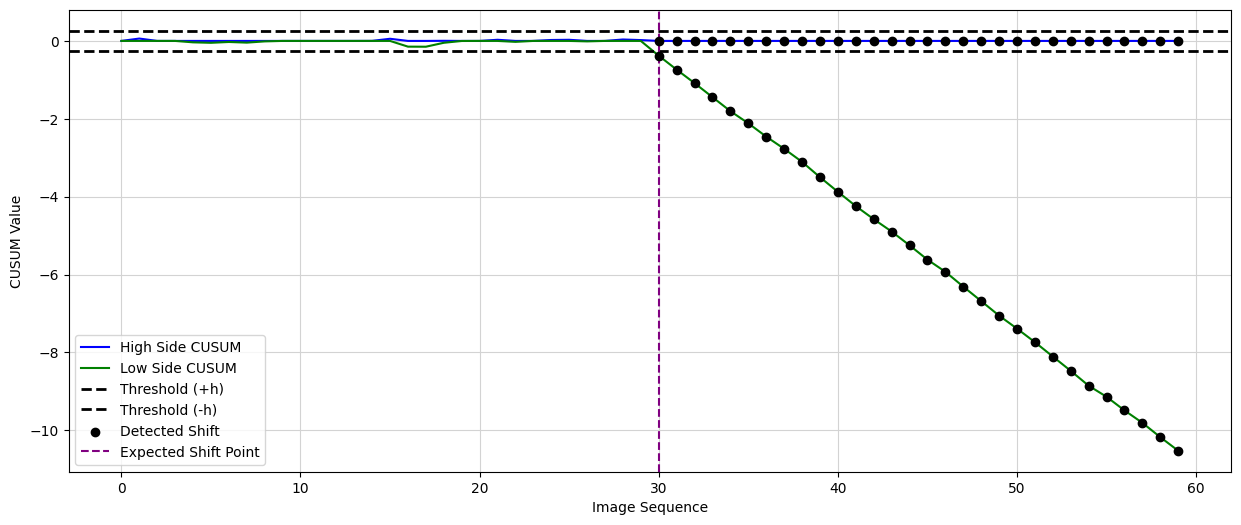

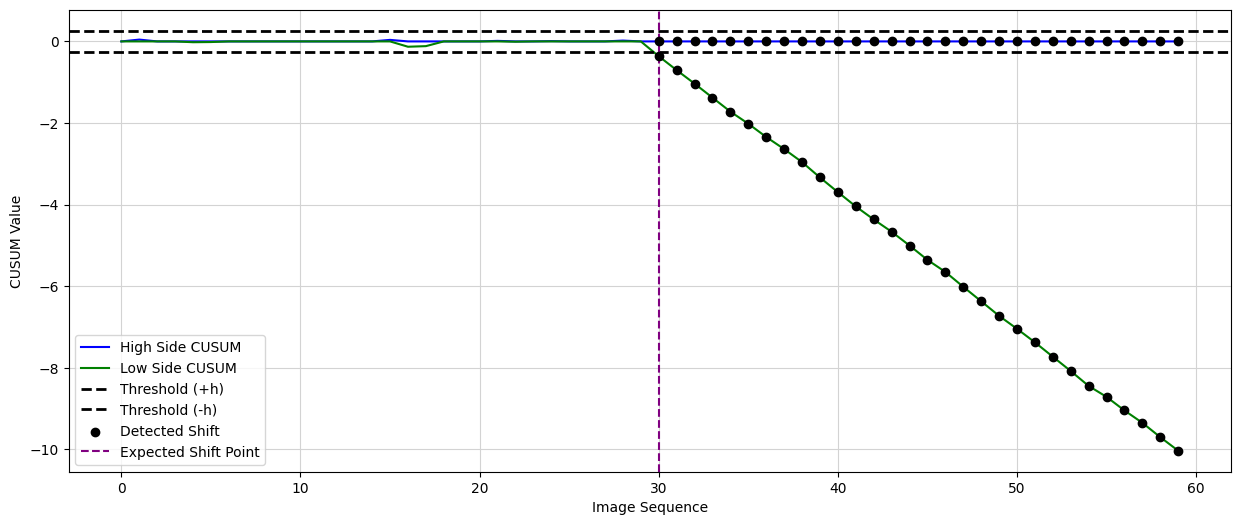

In [84]:
summary_df = pd.DataFrame(columns=["Threshold", "False Positives", "True Positives", "Average Detection Delay", "MTBFA", "False Alarm Rate"])

for k_th in k_values:
    k = k_th * in_std
    h = control_limit * in_std  # h equal to 4*std

    # Call the CUSUM function
    signal, S_hi, S_lo = CUSUM(combined_in_out_samples, mu_in, k, h)
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(S_hi, label='High Side CUSUM', color='blue')
    ax.plot(S_lo, label='Low Side CUSUM', color='green')
    ax.axhline(y=h, color='black', linestyle='--', linewidth=2, label='Threshold (+h)')
    ax.axhline(y=-h, color='black', linestyle='--', linewidth=2, label='Threshold (-h)')
    ax.scatter(signal, [S_hi[i] for i in signal], color='black', zorder=5, label='Detected Shift')
    ax.scatter(signal, [S_lo[i] for i in signal], color='black', zorder=5)

    # Adding vertical lines for expected shift points (every 30 days starting from day 30)
    for day in range(30, total_days+1, 60):
      ax.axvline(x=day, color='purple', linestyle='--', label='Expected Shift Point' if day == 30 else "")

    #ax.set_title(f'Processing for k = {k}')
    ax.set_facecolor('white')  # White background

    ax.set_xlabel('Image Sequence')
    ax.set_ylabel('CUSUM Value')
    ax.legend()
    ax.grid(True, color='lightgrey')  # Black grid lines
    plt.show()

     # Calculate False Positives
    for i in range(pre_change_days):
        if S_hi[i] > h or S_lo[i] > -h:  # Assuming symmetry around zero for S_lo
            FalsePos.append(i + 1)
            DetectionTimes.append(i + 1)

    # Calculate True Positives and Detection Delay
    for i in range(pre_change_days, total_days):
        if S_hi[i] > h or S_lo[i] > -h:
            TruePos.append(i + 1)
            AvgDD.append(i + 1 - pre_change_days)
            break  # Remove this break if you want to count all true positives


    # Calculate MTBFA and False Alarm Rate for the current threshold
    #MTBFA = np.mean(DetectionTimes) if DetectionTimes else float('inf')  # Avoid division by zero
    #FalseAlarmRate = 1 / MTBFA if DetectionTimes else 0



    # Append the results to the DataFrame
    #summary_df = summary_df.append({
    #    "Threshold": k_th,
    #    "False Positives": len(FalsePos),
    #    "True Positives": len(TruePos),
    #    "Average Detection Delay": np.mean(AvgDD) if AvgDD else 'N/A',
    #    "Minimum Delay": np.min(AvgDD) if AvgDD else 'N/A',
    #    "Maximum Delay": np.max(AvgDD) if AvgDD else 'N/A',
    #    "MTBFA": MTBFA if DetectionTimes else 'N/A',
    #    "False Alarm Rate": FalseAlarmRate,
    #    "In-control Std Dev": in_std,
    #    "In-control Mean": mu_in,
    #    "Out-of-control Mean": mu_out,
    #}, ignore_index=True)




# Print the summary table
#print(summary_df.to_string(index=False))

In [116]:
# ----in-control---cosine simailrty----
#df = pd.read_csv(r"/gpfs_projects/smriti.prathapan/EMBED/CUSUM_data_average_day_0357.csv")

# Compute the mean and std for in-conteol and out-control

#print(len(CUSUM_data_average_day))
#print(CUSUM_data_average_day.shape)

Cosine_in_control = CUSUM_data_average_day[:30]
Cosine_out_control = CUSUM_data_average_day[31:60]

mu0 = np.mean(Cosine_in_control)
in_std  = np.std(Cosine_in_control)

mu1 = np.mean(Cosine_out_control)
out_std  = np.std(Cosine_out_control)

print("mean for in-control mu0 is:", mu0)
print("std for in-control is:", in_std)
print("mean for out-control mu1 is:", mu1)
print("std for out-control is:", out_std)



mean for in-control mu0 is: 0.5174694948742787
std for in-control is: 0.005228654198626145
mean for out-control mu1 is: 0.5019937126621091
std for out-control is: 0.006154632407484587


In [86]:
def CUSUM(x, mu0, k, h):
    S_hi = [0]
    S_lo = [0]
    for i in range(len(x)):
        S_hi.append(max(0, S_hi[i] + (x[i] - mu0 - k)))
        S_lo.append(min(0, S_lo[i] + (x[i] - mu0 + k)))

    S_hi = np.array(S_hi[1:])
    S_lo = np.array(S_lo[1:])

    signal_hi = np.where(S_hi > h)[0]
    signal_lo = np.where(S_lo < -h)[0]
    signal = np.unique(np.concatenate((signal_hi, signal_lo)))

    return signal, S_hi, S_lo



In [87]:
# Define the range of k values as a fraction of in_std
k_values = [0.1, 0.25, 0.5, 0.75, 1.0]
# Specify the control parameters and the threshold
pre_change_days = 30  # Number of days the process is in-control
total_days = 60  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
delta = 1  # Change magnitude in terms of standard deviations

# Split your data into in-control and out-of-control periods
in_control_sp = CUSUM_data_average_day[:pre_change_days]
out_control_sp = CUSUM_data_average_day[pre_change_days:total_days]

# Compute the mean and standard deviation for in-control and out-of-control periods
mu_in = np.mean(in_control_sp)
mu_out = np.mean(out_control_sp)
in_std = np.std(in_control_sp)


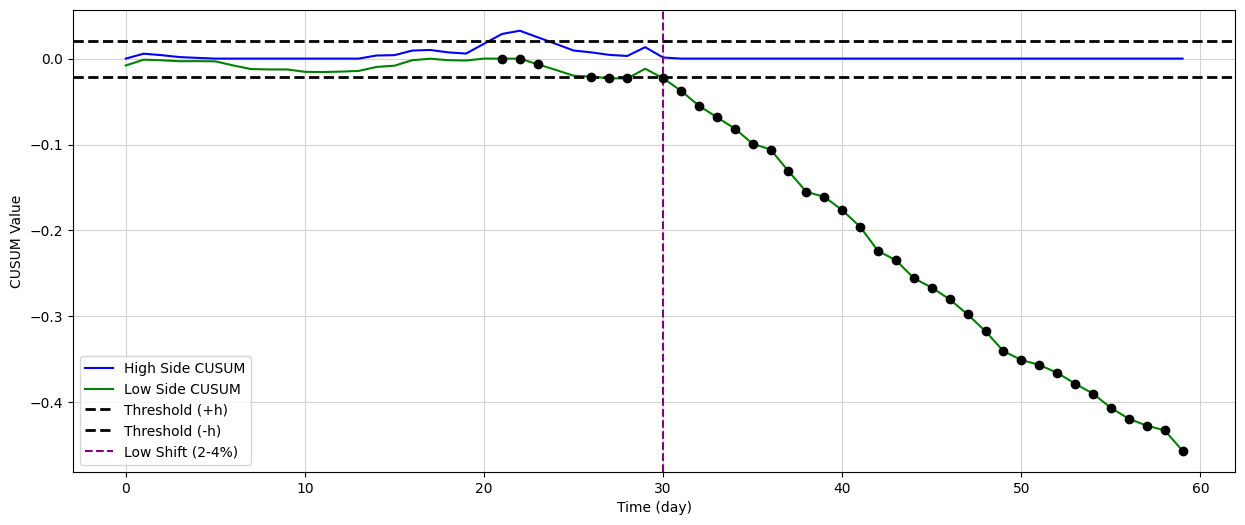

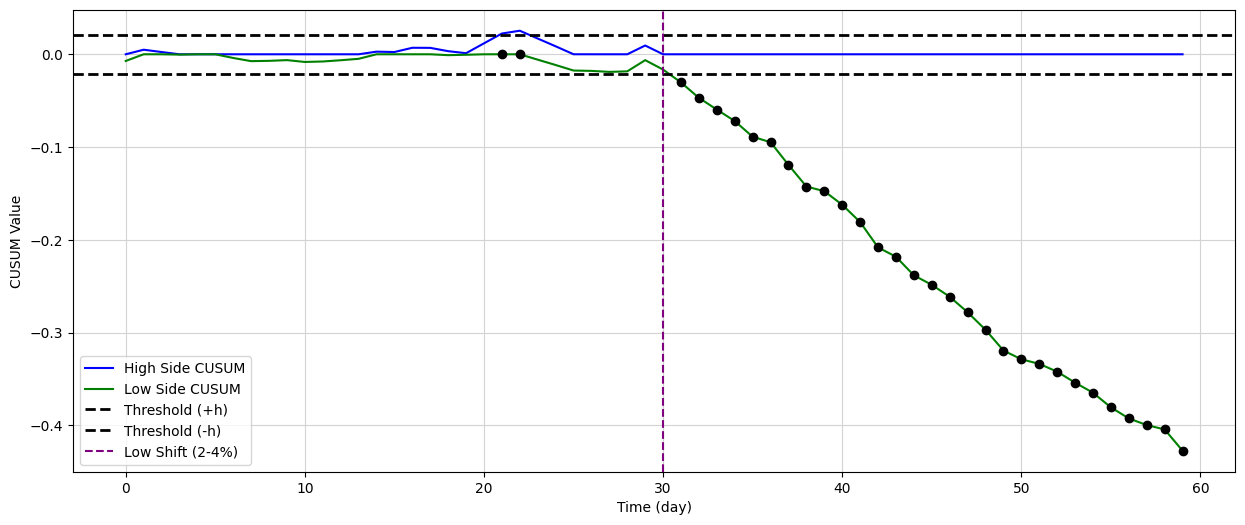

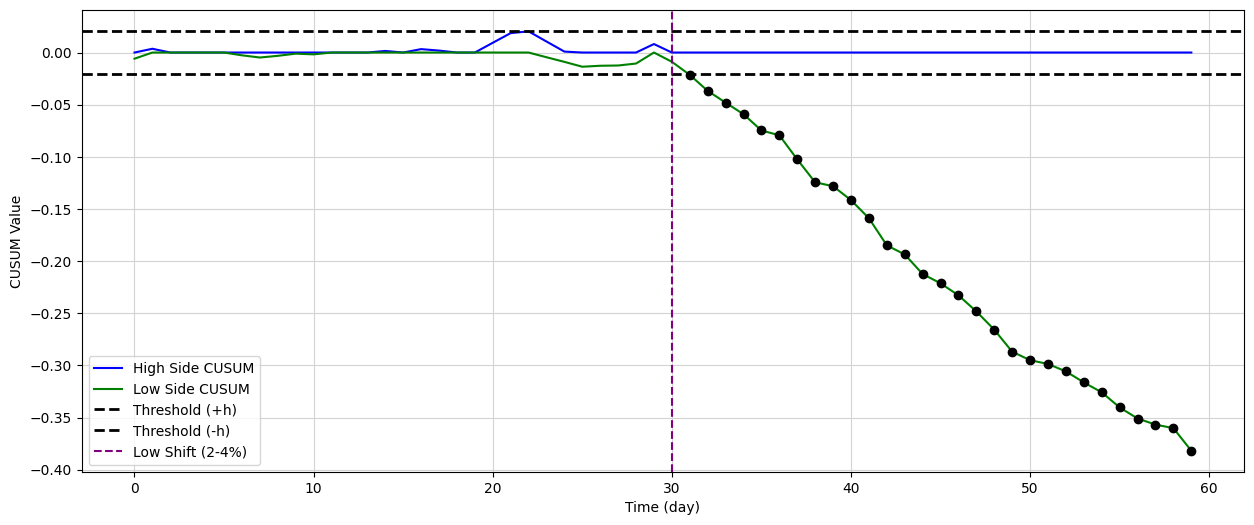

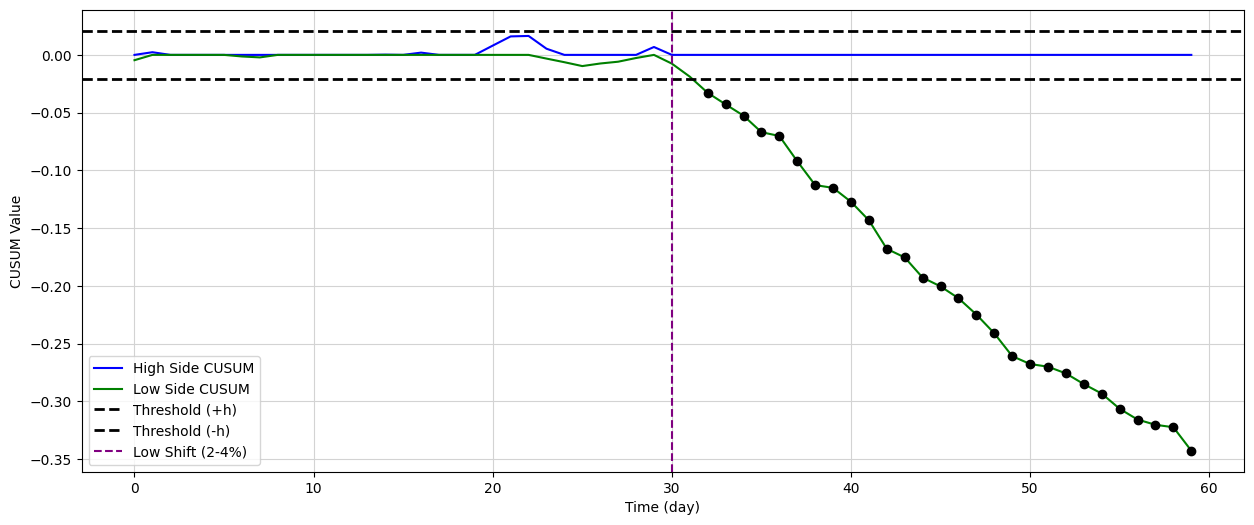

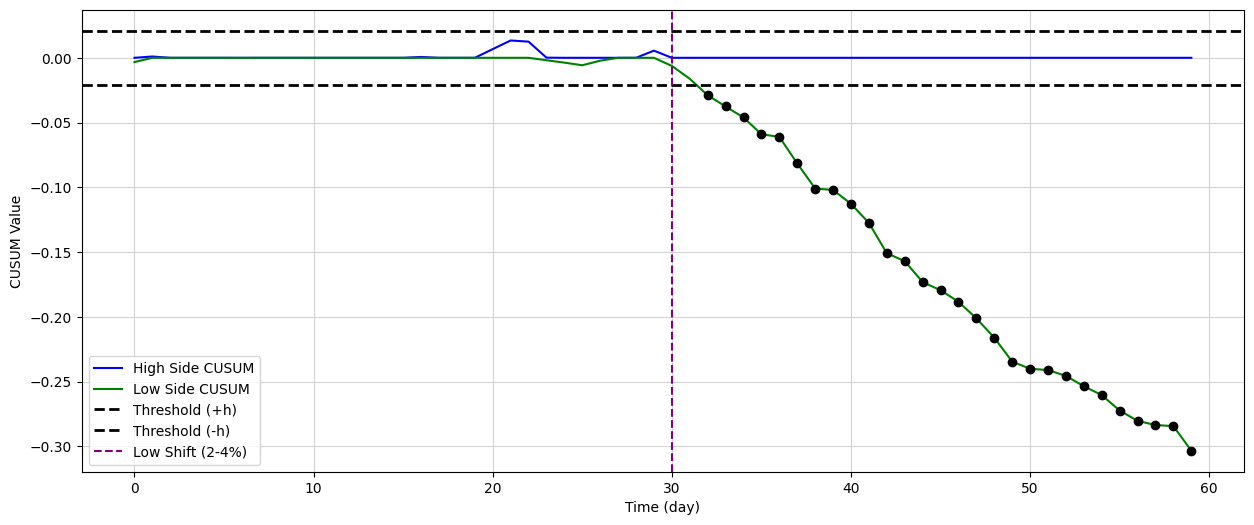

In [94]:
for k_th in k_values:
    k = k_th * in_std
    h = control_limit * in_std  # h equal to 4*std

    # Initialize lists to store results
    FalsePos = []
    TruePos = []
    AvgDD = []  # Average Detection Delay
    DetectionTimes = []

    # Call the CUSUM function
    signal, S_hi, S_lo = CUSUM(CUSUM_data_average_day, mu_in, k, h)
    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))

    ax.plot(S_hi, label='High Side CUSUM', color='blue')
    ax.plot(S_lo, label='Low Side CUSUM', color='green')
    ax.axhline(y=h, color='black', linestyle='--', linewidth=2, label='Threshold (+h)')
    ax.axhline(y=-h, color='black', linestyle='--', linewidth=2, label='Threshold (-h)')
    #ax.scatter(signal, [S_hi[i] for i in signal], color='black', zorder=5, label='Detected Shift')
    ax.scatter(signal, [S_lo[i] for i in signal], color='black', zorder=5)

    # Adding vertical lines for expected shift points (every 30 days starting from day 30)
    #for day in range(30, total_days+1, 50):
    #  ax.axvline(x=day, color='purple', linestyle='--', label='Expected Shift Point' if day == 30 else "")


    # Indicate the first shift point
    ax.axvline(x=30, color='purple', linestyle='--', label='Low Shift (2-4%)')  # Purple line for shift start
    # Indicate the second shift point
    #ax.axvline(x=40, color='purple', linestyle='--', label='Second Shift (moderate)')  # Purple line for shift start
    # Indicate the third shift point
    #ax.axvline(x=70, color='purple', linestyle='--', label='Third Shift (high)')  # Purple line for shift start

    #ax.set_title(f'Processing for k = {k}')
    ax.set_facecolor('white')  # White background

    ax.set_xlabel('Time (day)')
    ax.set_ylabel('CUSUM Value')
    ax.legend()
    ax.grid(True, color='lightgrey')  # Black grid lines
    plt.show()

     # Calculate False Positives
    for i in range(pre_change_days):
        if S_hi[i] > h or S_lo[i] > -h:  # Assuming symmetry around zero for S_lo
            FalsePos.append(i + 1)
            DetectionTimes.append(i + 1)

    # Calculate True Positives and Detection Delay
    for i in range(pre_change_days, total_days):
        if S_hi[i] > h or S_lo[i] > -h:
            TruePos.append(i + 1)
            AvgDD.append(i + 1 - pre_change_days)
            break  # Remove this break if you want to count all true positives


    # Calculate MTBFA and False Alarm Rate for the current threshold
    #MTBFA = np.mean(DetectionTimes) if DetectionTimes else float('inf')  # Avoid division by zero
    #FalseAlarmRate = 1 / MTBFA if DetectionTimes else 0




In [125]:
from google.colab import drive

# Now, change the directory to the location of your file
# Replace 'your/path/' with the actual path to the folder containing 'CUSUM_detector.py'
%cd /content/drive/My Drive/Colab Notebooks

# You can check if your file is there
import os
print(os.listdir())

# Now, try importing your module
import CUSUM_detector




/content/drive/My Drive/Colab Notebooks
['Untitled0.ipynb', 'AI_monitoring.ipynb', 'AI_OOD.ipynb', 'CLB_generative.ipynb', 'OOD_texture.ipynb', 'tSNE_Features.ipynb', 'Kesavan_code_SPC.ipynb', 'GANEval_Text.ipynb', 'SPC_charts_functions.ipynb', 'Untitled', 'CUSUM_Charts_average.ipynb', 'OOD_deep_features_old.ipynb', 'CUSUM_Charts.ipynb', 'Untitled2.ipynb', 'Untitled1.ipynb', 'OOD_Data_Prepration.ipynb', 'OOD_image_statistics.ipynb', 'SPC_Applied_to_Extracted_Features.ipynb', 'OOD_deep_features.ipynb', 'Chart_Final.ipynb', 'Contrastive_Chart.ipynb', 'Autoencoder_Chart.ipynb', 'VGG16_Classification.ipynb', 'CXR_Exper.ipynb', 'Stats_Texture_BaselineSPC.ipynb', 'modality-agnostic.ipynb', 'CXR_SPC_Simulation.ipynb', 'CLB_clusters.ipynb', 'Copy of dcgan_faces_tutorial.ipynb', 'CLB_dcgan_tutorial.ipynb', 'CLB_Gen.ipynb', 'Dataset_agnostic.ipynb', 'VGG16_CXR_Chart.ipynb', '__pycache__', 'CUSUM_detector.py']


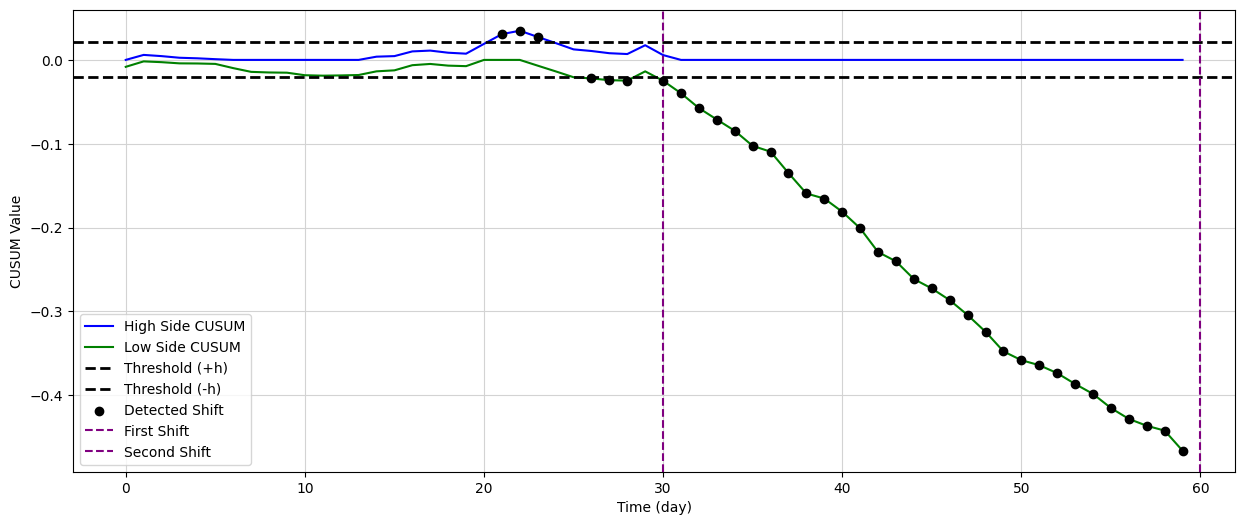

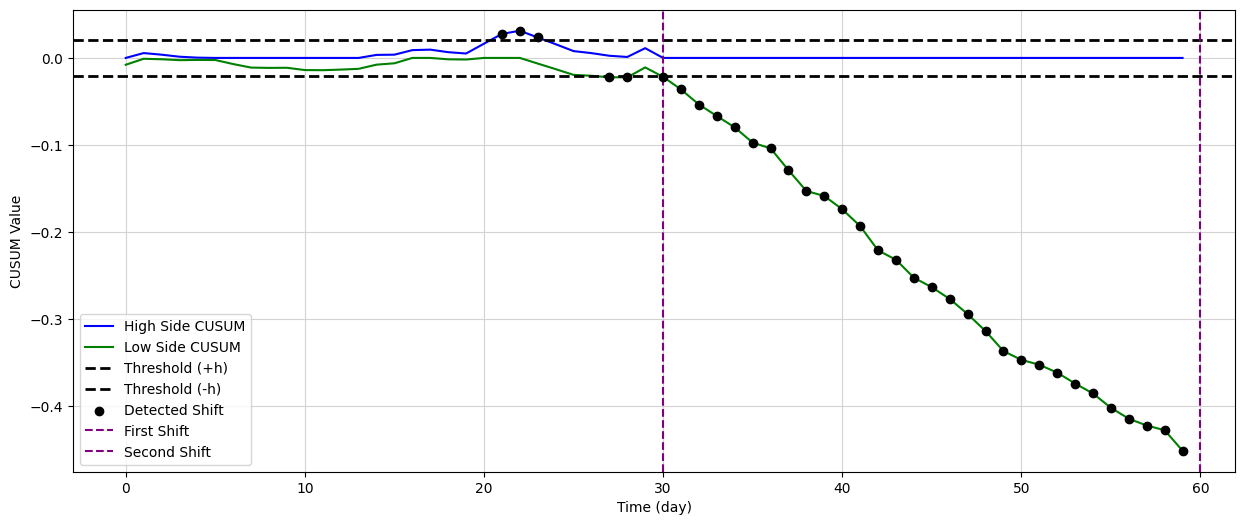

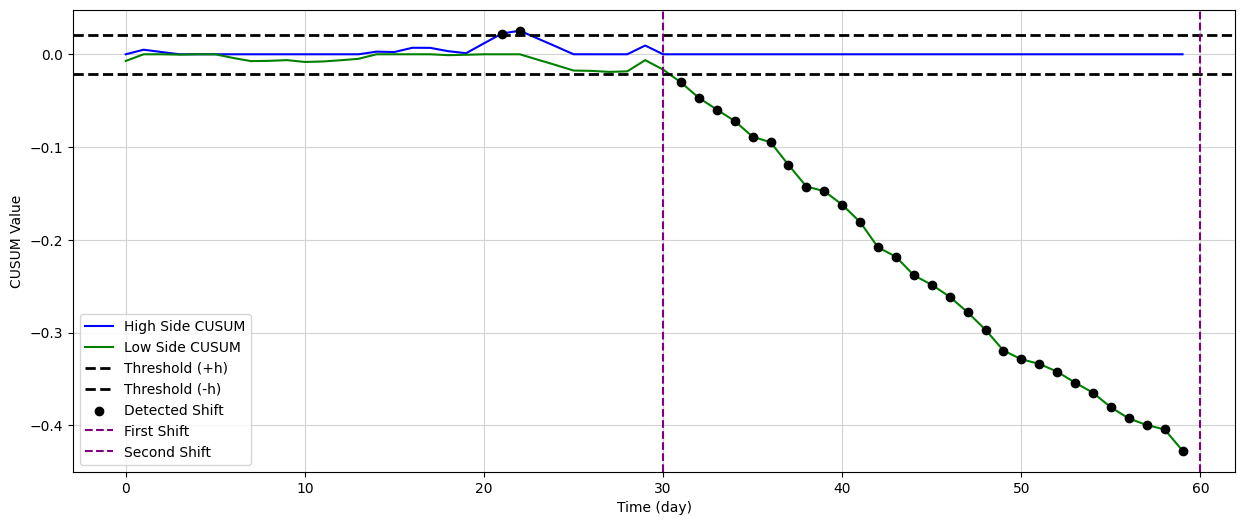

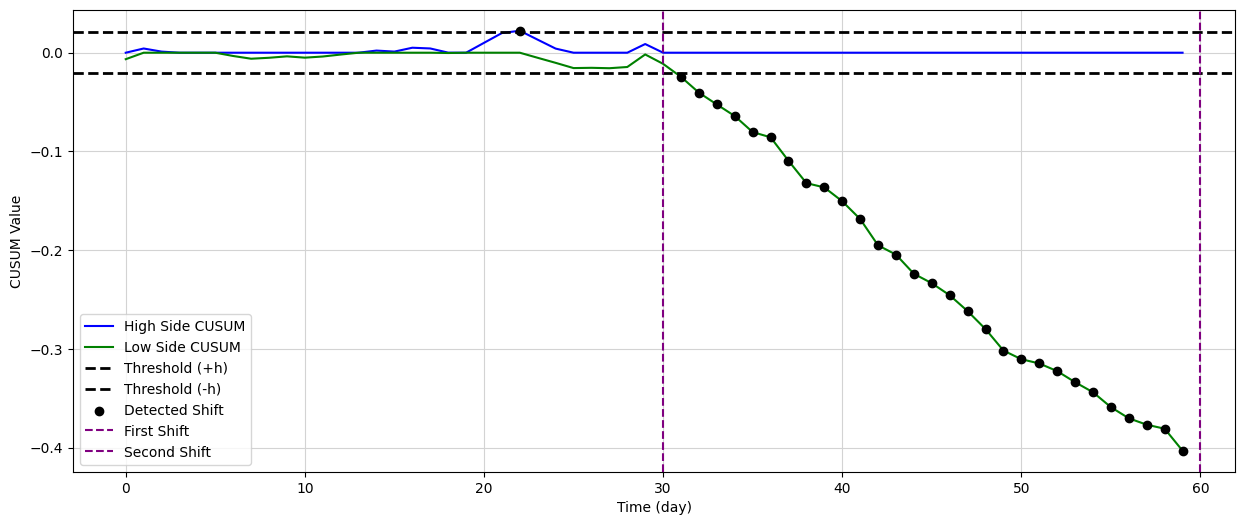

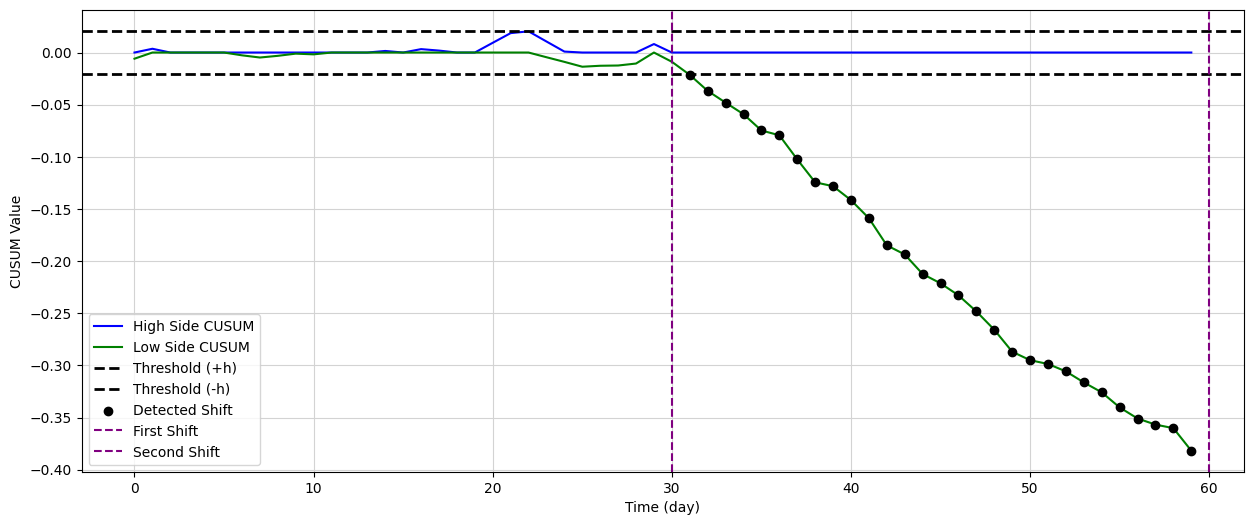

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [126]:
"""CUSUM"""
# Specify the control parameters and the threshold
pre_change_days = 30  # Number of days the process is in-control
total_days = 60  # Total number of days in the dataset
control_limit = 4  # Multiplier for control limit
detector = CUSUM_detector.CUSUMChangeDetector(pre_change_days, total_days)
ks = [0.1, 0.25, 0.5, 0.75, 1.0]
for k in ks:
    detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, k, save_plot=False)


 k value  Threshold  False Positives  True Positives  Average Detection Delay  MTBFA  False Alarm Rate
    0.10        4.0              6.0             1.0                      0.0   24.5          0.040816
    0.25        4.0              5.0             1.0                      0.0   24.2          0.041322
    0.50        4.0              2.0             1.0                      1.0   21.5          0.046512
    0.75        4.0              1.0             1.0                      1.0   22.0          0.045455
    1.00        4.0              0.0             1.0                      1.0    NaN               NaN


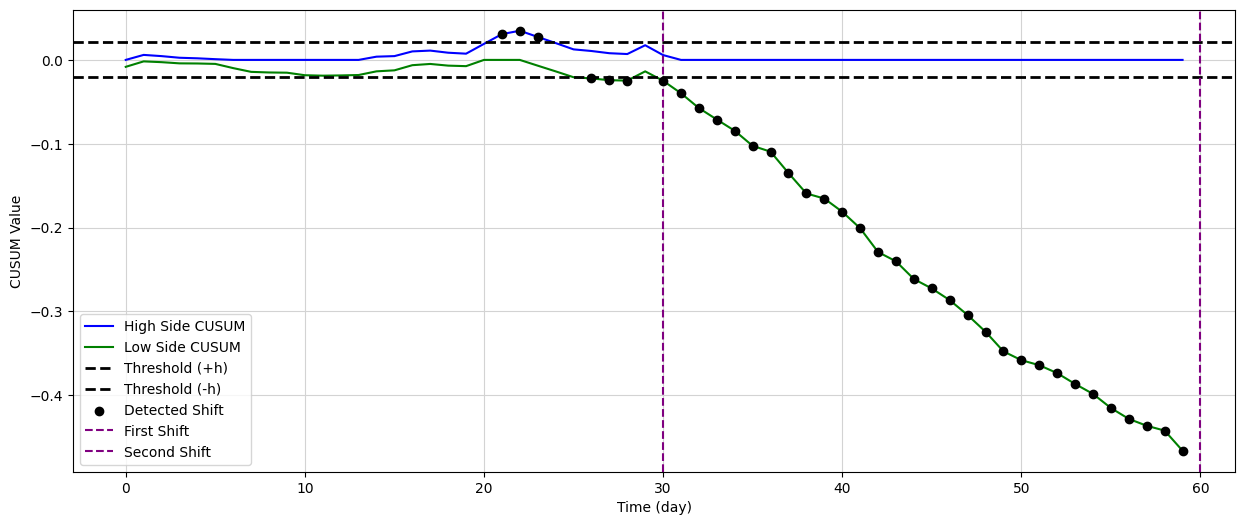

In [127]:
# Choose best k
print(detector.summary())
# Save CUSUM for best k
detector.changeDetection(CUSUM_data_average_day, pre_change_days, total_days, control_limit, 0.10, save_plot=False)


## Same as above but with mahalanobis distance

In [ ]:

# Example usage:
# Assuming train_features, test_in_dist_features, and test_out_dist_features are defined
mahalanobis_train_similarities_VGG16 = compute_similarity(training_features, training_features, "mahalanobis")
mahalanobis_train_similarities_actaul_VGG16 = mahalanobis_train_similarities_VGG16['similarities']

mahalanobis_mean_train_VGG16 = mahalanobis_train_similarities_VGG16["mean"]
mahalanobis_std_train_VGG16 = mahalanobis_train_similarities_VGG16["std"]

mahalanobis_in_dist_similarities_VGG16 = compute_similarity(training_features, in_dist_features, "mahalanobis")
mahalanobis_out_dist_similarities_VGG16 = compute_similarity(training_features, out_dist_features, "mahalanobis")

mahalanobis_in_dist_similarities_VGG16_mean = mahalanobis_in_dist_similarities_VGG16["mean"]
mahalanobis_in_dist_similarities_VGG16_std = mahalanobis_in_dist_similarities_VGG16["std"]

mahalanobis_out_dist_similarities_VGG16_mean = mahalanobis_out_dist_similarities_VGG16["mean"]
mahalanobis_out_dist_similarities_VGG16_std = mahalanobis_out_dist_similarities_VGG16["std"]

print("mahalanobis - Mean train: {} | STD train: {}".format(mahalanobis_mean_train_VGG16, mahalanobis_std_train_VGG16))
print("mahalanobis - MEAN in-dist: {} | MEAN out-dist: {}".format(mahalanobis_in_dist_similarities_VGG16_mean, mahalanobis_in_dist_similarities_VGG16_std))
print("mahalanobis - STD out-dist: {} | STD out-dist: {}".format(mahalanobis_out_dist_similarities_VGG16_mean, mahalanobis_out_dist_similarities_VGG16_std))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create histograms
plt.figure(figsize=(18, 6))

# Training Features Histogram
plt.subplot(1, 3, 1)
plt.hist(mahalanobis_train_similarities_actaul_VGG16, bins=50, color='blue', alpha=0.7)
plt.title('Train Features')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

# In-Dist Features Histogram
plt.subplot(1, 3, 2)
plt.hist(mahalanobis_in_dist_similarities_VGG16['similarities'], bins=50, color='green', alpha=0.7)
plt.title('In-Dist Features')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

# Out-Dist Features Histogram
plt.subplot(1, 3, 3)
plt.hist(mahalanobis_out_dist_similarities_VGG16['similarities'], bins=50, color='red', alpha=0.7)
plt.title('Out-Dist Features')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Save the Mahalanobis distance arrays to .npy files
np.save('/content/drive/My Drive/mahalanobis_train_similarities_VGG16.npy', mahalanobis_train_similarities_actaul_VGG16)
np.save('/content/drive/My Drive/mahalanobis_in_dist_similarities_VGG16.npy', mahalanobis_in_dist_similarities_VGG16['similarities'])
np.save('/content/drive/My Drive/mahalanobis_out_dist_similarities_VGG16.npy', mahalanobis_out_dist_similarities_VGG16['similarities'])

# Save the Mahalanobis distance arrays to .npy files
np.save('/content/drive/My Drive/cosine_train_similarities_VGG16.npy', cosine_train_similarities_actaul_VGG16)
np.save('/content/drive/My Drive/cosine_in_dist_similarities_VGG16.npy', cosine_in_dist_similarities_VGG16_actual)
np.save('/content/drive/My Drive/cosine_out_dist_similarities_VGG16.npy', cosine_out_dist_similarities_VGG16_actual)

print("Mahalanobis and cosine distances and statistics saved successfully.")
